# RATINGS

Per cominciare il progetto, iniziamo importando i file csv all'interno di dei dataframe pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
import urllib3
from tqdm import tqdm
import networkx as nx

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
# Disable all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1. Lettura del dataset

In [3]:

dataset_path = "./dataset/"

def load_data(dataset_path):
    inputs = pd.read_csv(dataset_path + "inputs.csv", header=None)
    outputs = pd.read_csv(dataset_path + "outputs.csv", header=None)
    mapping = pd.read_csv(dataset_path + "mapping.csv", header=None)
    transactions = pd.read_csv(dataset_path + "transactions.csv", header=None)
    return inputs, outputs, mapping, transactions


print("Loading data...")
inputs, outputs, mapping, transactions = load_data(dataset_path)
print("Done...")

Loading data...
Done...


### 1.1. Preprocessing
#### Aggiunta colonne e downscaling dei tipi
La prima cosa evidente quando leggo questi CSV, è che non è presente il column name nei file, dunque per comodità, seguendo la traccia li aggiungerò io.

In aggiunta, downscalerò i tipi default (np.int64) alla minore grandezza possibile, così da risparmiare memoria e quindi tempo nelle operazioni.

In [4]:
print("Adding headers to the dataframes...")
# headers transaction
transactions.columns = ["timestamp", "blockId", "txId", "isCoinbase", "fee"]
# headers mapping
mapping.columns = ["hash","addressId" ]
# headers inputs
inputs.columns = ["txId", "prevTxId", "prevTxpos"]
# headers outputs
outputs.columns = ["txId", "position", "addressId", "amount", "scripttype"]
print("Done...")

# In aggiunta, andrò a downcastare ad int16 i campi che posso
# Questo downcast è possibile in quanto i valori presenti nei campi sono tutti numeri interi
# Andrà in automatico al valore minimo possibile per quel campo
print("Downcasting data...")
# Transactions
transactions['timestamp'] = pd.to_numeric(transactions['timestamp'], downcast='integer')
transactions['blockId'] = pd.to_numeric(transactions['blockId'], downcast='integer')
transactions['txId'] = pd.to_numeric(transactions['txId'], downcast='integer')
transactions['fee'] = pd.to_numeric(transactions['fee'], downcast='integer')

# Convert isCoinbase to categorical if it's binary
transactions['isCoinbase'] = transactions['isCoinbase'].astype('category')

# Inputs
inputs['txId'] = pd.to_numeric(inputs['txId'], downcast='integer')
inputs['prevTxId'] = pd.to_numeric(inputs['prevTxId'], downcast='integer')
inputs['prevTxpos'] = pd.to_numeric(inputs['prevTxpos'], downcast='integer')

# Outputs
outputs['txId'] = pd.to_numeric(outputs['txId'], downcast='integer')
outputs['position'] = pd.to_numeric(outputs['position'], downcast='integer')
outputs['addressId'] = pd.to_numeric(outputs['addressId'], downcast='integer')
outputs['amount'] = pd.to_numeric(outputs['amount'], downcast='integer')
outputs['scripttype'] = outputs['scripttype'].astype('category')
print("Done...")

Adding headers to the dataframes...
Done...
Downcasting data...
Done...


#### Filtro per le transazioni invalide
Prima di continuare con le analisi e lo scraping dei dati, è importantissimo controllare che le transazioni che abbiamo nel dataset siano valide.
In particolare ci interessa controllare:
 - Che non ci siano input o output che non fanno riferimento ad una transazione reale
 - Input che fanno riferimento a transazioni non esistenti (quindi spendi btc non esistenti)
 - Output con "amount" negativi
 - Transazioni con fees negative
 - Double spending transactions
 - Transazioni con lo stesso id

In [5]:
# Input invalidi
invalidInput = inputs[~ inputs.txId.isin(transactions['txId'])] #Input che non hanno un txId corrispondente in transactions
invalidOutput = outputs[~ outputs.txId.isin(transactions['txId'])] #Output che non hanno un txId corrispondente in transactions

print("Invalid inputs: ", invalidInput.shape[0])
print("Invalid outputs: ", invalidOutput.shape[0])
# Sono entrambi vuoti, quindi non ci sono input o output che non hanno un txId corrispondente in transactions (le transazioni sono dunque valide da questo punto di vista)

# Input che non hanno un prevTxId corrispondente in outputs
invalidPrevTxId = inputs[~ inputs.prevTxId.isin(outputs['txId'])]
print("Invalid prevTxId: ", invalidPrevTxId.shape[0])
# Anche qui sono 0

# Output con amount negativi
invalidAmount = outputs[outputs.amount < 0]
print("Invalid amount: ", invalidAmount.shape[0])

# Fees negative 
invalidFees = transactions[transactions.fee < 0]
print("Invalid fees: ", invalidFees.shape[0])

# Double spending transactions
double_spending = inputs[['txId', 'prevTxId', 'prevTxpos']].merge(transactions[['txId', 'timestamp']].astype('int64'), on='txId', how='left')
double_spending['group_count'] = double_spending.groupby(['prevTxId', 'prevTxpos'])['txId'].transform('count')
double_spending = double_spending[double_spending['group_count'] > 1]
double_spending.drop(columns=['group_count'], inplace=True)

print("Double spending transactions: ", double_spending.shape[0])


# Same id transactions
same_id = transactions['txId'].value_counts()
same_id = same_id[same_id > 1]

print("Same id transactions: ", same_id.shape[0])

Invalid inputs:  0
Invalid outputs:  0
Invalid prevTxId:  0
Invalid amount:  0
Invalid fees:  0
Double spending transactions:  0
Same id transactions:  2


Sfortunatamente quello che notiamo è che esistono due txId che sono correlati a più transazioni. Quello che facciamo allora è eliminarle da transactions, inputs e outputs.

In [6]:
# i txId sono già in same_id, basta semplicemente rimuoverle controllando se il txId è presente nell'index di same_id
transactions = transactions[~ transactions.txId.isin(same_id.index)]
inputs = inputs[~ inputs.txId.isin(same_id.index)]
outputs = outputs[~ outputs.txId.isin(same_id.index)]

Adesso che abbiamo effettuato questo passo di preprocessing, non ci sono altre transazioni che risultano invalide e dunque possiamo tranquillamente continuare nella nostra analisi

### Informazioni generali reperite dalla traccia per gli esercizi successivi
Come spiegato dalla traccia, determinati scripttype hanno una dimensione in byte e un nome associato. In aggiunta, le transazioni hanno una average input size e una average output size.

Quello che faccio è aggiungerli al mio ambiente in strutture efficienti così da poterli utilizzare dopo

In [7]:
# Tutto quanto in bytes
scriptsizes = {
    0: 0,          #Unkown script, size 0...
    1: 153,        #P2PK, Una delle prime versione dello script di pagamento
    2: 180,        #P2PKH, Uno degli script di pagamento più comuni all'epoca
    3: 291         #P2PSH, A P2SH transaction is a transaction whose inputs were locked using a P2SH ScriptPubKey.
}
script_name_map = {
    0: "Unknown",
    1: "P2PK",
    2: "P2PKH",
    3: "P2PSH"
}
avg_input_size = 40     #Dimensione media di un input (da traccia)
avg_output_size = 9     #Dimensione media di un output (da traccia)

## 2. Analisi generali di dati sulla blockchain
### 2.1. Analisi della correlazione tra la congestione ed il costo delle fees
Una delle primissime analisi che ci prendiamo la premura di fare, è quella dell'andamento delle fees rispetto alla congestione della blockchain. Ovvero ci interessa capire se all'aumentare della congestione, aumentano anche le fees. 
La formula che ci restituisce la dimensione in byte di una transazione è la seguente:
$$ size(transaction) = size(input)*\text{n\_inputs} + size(output)* \text{n\_outputs} + size(script)$$
A questo punto la congestione non è altro che la somma delle dimensioni delle transazioni dato un intervallo di tempo. 
L'idea ora è mergiare le transaction, calcolando quanti input ed output ci sono per ognuna e mergiando il risultato del calcolo. A questo punto è importante anche mergiare la script_size corrispettiva (infierendola da uno degli output correlati) e poi calcolare la size della transaction in maniera il più possibile efficiente.
Poi analizzerò il risultato plottando il tutto in un grafico che avrà entrambi gli indici (fee e transaction_size) nello stesso plot, per accorgermi velocemente di eventuali relazioni. Potrei eventualmente anche calcolare la correlazione tra i due indici.

In [8]:
# Filtriamo prima per le sole transazioni non coinbase
print("Filtering non-coinbase transactions...")
non_coinbase_transactions = transactions[transactions['isCoinbase'] == 0]
print("Done...")
print(f"Removed {transactions.shape[0]-non_coinbase_transactions.shape[0]} coinbase transactions...")
# Calcolo del numero di input e output per ogni transazione
print("Computing the number of inputs and outputs for each transaction...")
input_counts = inputs[inputs["txId"].isin(non_coinbase_transactions["txId"])].groupby('txId').size().reset_index(name='n_inputs')
output_counts = outputs[outputs["txId"].isin(non_coinbase_transactions["txId"])].groupby('txId').size().reset_index(name='n_outputs')
print("Done...")

print(f"Number of transactions considered: {non_coinbase_transactions.shape[0]}")
print(f"Input counts len:{input_counts.shape[0]}")
print(f"Output counts len:{output_counts.shape[0]}")

# Ora posso permettermi di mergiare i conteggi con le transazioni (sempre sulle non_coinbase)
print("Merging the input and output counts with the transactions...")
non_coinbase_transactions = non_coinbase_transactions.merge(input_counts, on='txId', how='left').fillna(0)
non_coinbase_transactions = non_coinbase_transactions.merge(output_counts, on='txId', how='left').fillna(0) #Per sicurezza il fillna ce lo metto ma non dovrebbero esserci problemi alcuni
print("Done...")

# A questo punto sono interessato a capire qual è lo script utilizzato da una transazione.
# Per fare ciò, mi basta controllare il campo scripttype di outputs e fare un merge con le transazioni

print("Merging the script type with the transactions...")
non_coinbase_transactions = non_coinbase_transactions.merge(outputs[['txId', 'scripttype']].drop_duplicates(subset="txId"), on='txId', how='left') #Droppo i duplicati perchè non mi interessano
print("Done...")
#Ora posso prendermi la briga di associare ogni script al suo scriptsize con una map
print("Mapping the script type to the script size...")
non_coinbase_transactions['script_size'] = non_coinbase_transactions['scripttype'].map(scriptsizes).astype('int') #As int perchè devo farci delle operazioni su interi dopo
print("Done...")

#Adesso che ho n_inputs, n_outputs e script_size tutti nel dataframe non_coinbase_transactions (Ovvero tutte le transazioni non coinbase), posso calcolare la size di ogni transazione in maniera vettoriale e dunque efficente
print("Computing the size of the transactions...")
non_coinbase_transactions['size'] = (non_coinbase_transactions['n_outputs']+non_coinbase_transactions['script_size'])*avg_output_size + non_coinbase_transactions['n_inputs']*avg_input_size
print("Done...")

Filtering non-coinbase transactions...
Done...
Removed 214559 coinbase transactions...
Computing the number of inputs and outputs for each transaction...
Done...
Number of transactions considered: 10358266
Input counts len:10358266
Output counts len:10358266
Merging the input and output counts with the transactions...
Done...
Merging the script type with the transactions...
Done...
Mapping the script type to the script size...
Done...
Computing the size of the transactions...
Done...


Ora che abbiamo con successo computato la size per ogni transazione, procediamo illustrando uno dei possibili grafici per portare avanti l'analisi. 
In aggiunta, possiamo calcolare un coefficiente di correlazione fra le due colonne.

Number of blocks: 130652


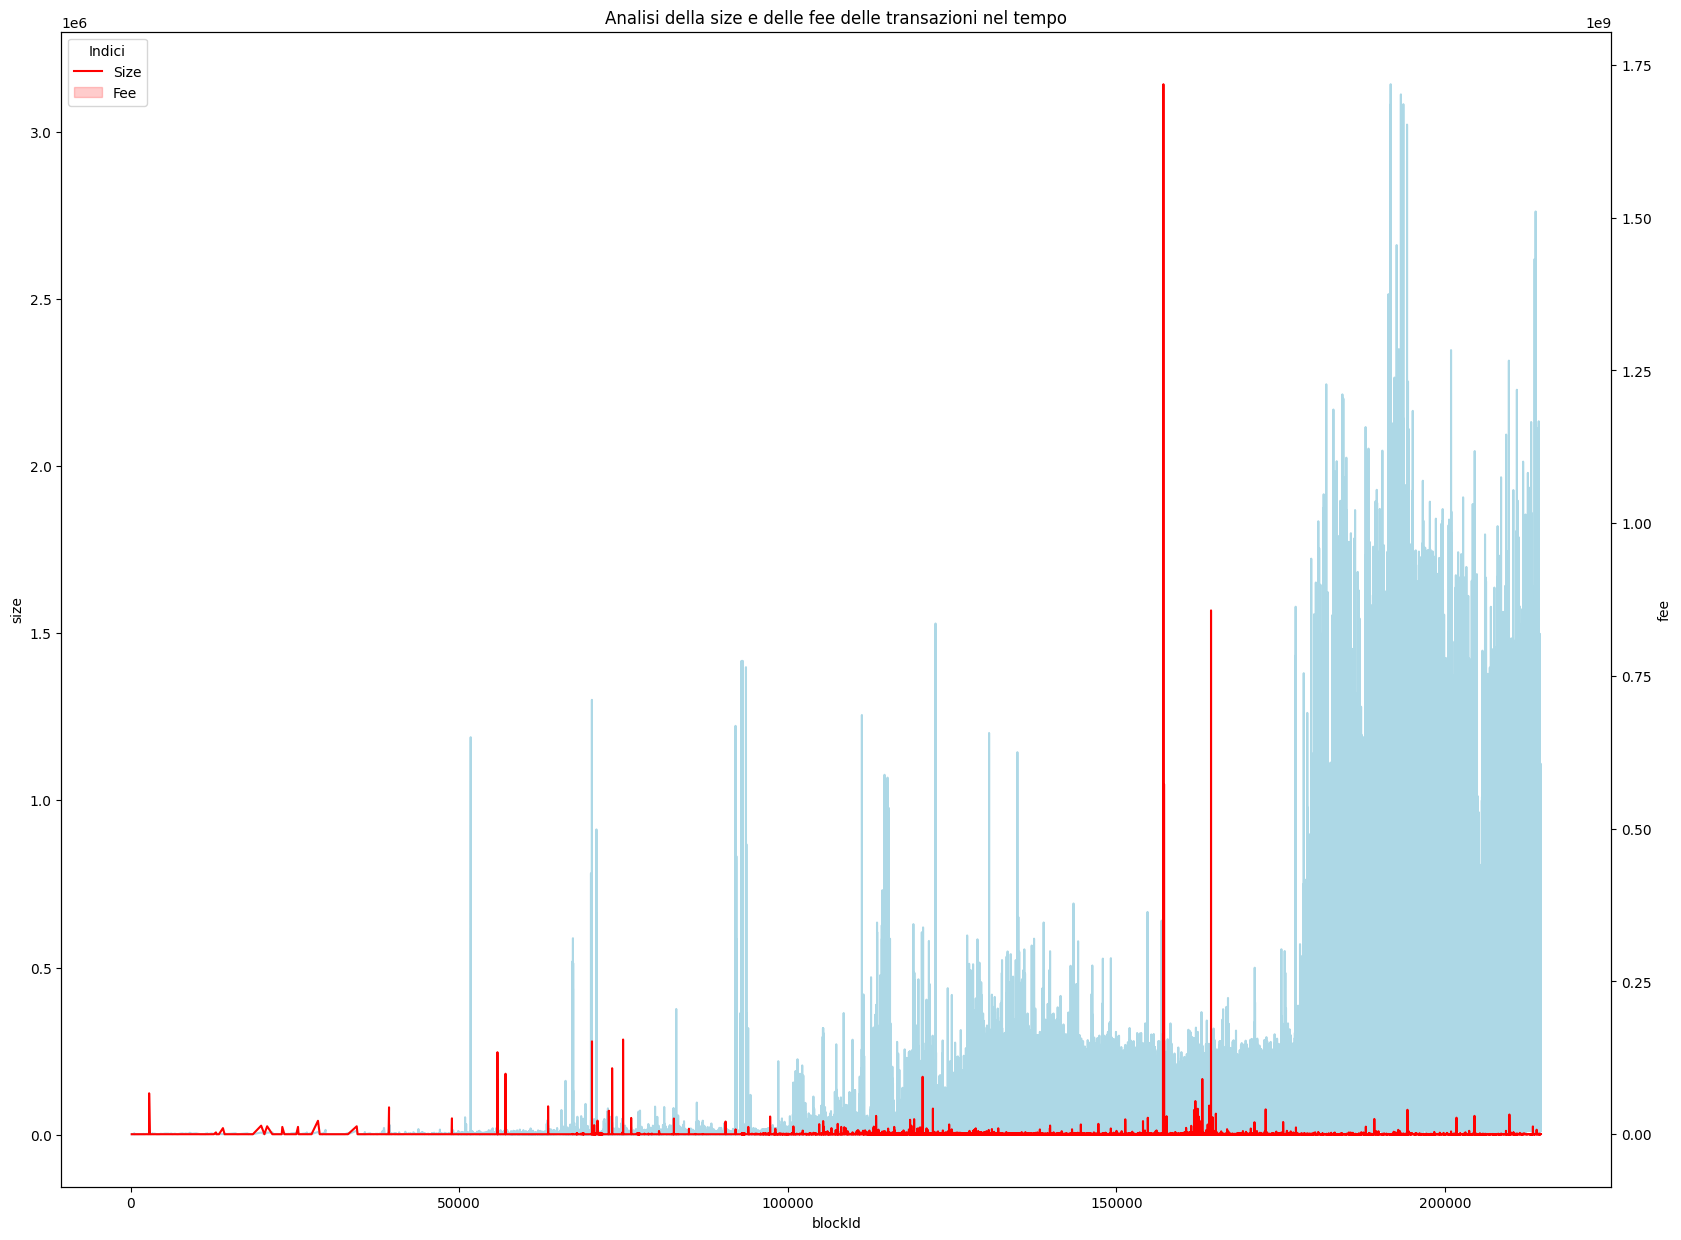

In [9]:
# Ci torna comodo trasformare il timestamp in un tipo data
non_coinbase_transactions['date'] = pd.to_datetime(non_coinbase_transactions['timestamp'], unit='s')
print("Number of blocks:", len(non_coinbase_transactions["blockId"].unique())) 
# Proviamo ad usare i blocchi come indice temporale, considerando che un blocco è un insieme di transazioni che avvengono in un certo intervallo di tempo e non può in nessun caso superare 1 milione di vbytes

# Gruppo per blockId e calcolo la somma delle transazioni per intervallo e la media delle fees 
grouped = non_coinbase_transactions.groupby("blockId").agg({ #Funzione di aggregazione
    'size': 'sum', #Somme delle size per intervallo, la congestione
    'fee': 'mean' #Media delle fee per intervallo, il costo medio di una transazione
}).reset_index()

# Proviamo a vedere separatamente come si comportano questi due indici in due grafici affiancati
fig, ax =plt.subplots() #Creo la figura
ax2 = ax.twinx() #Clono l'asse
fig.set_figheight(15)
fig.set_figwidth(20)
sns.lineplot(data=grouped, x='blockId', y='size', ax=ax, color='lightblue') 
sns.lineplot(data=grouped, x='blockId', y='fee', ax=ax2, color='red')
plt.legend(title="Indici", labels=['Size', 'Fee'], loc='upper left')
plt.title('Analisi della size e delle fee delle transazioni nel tempo')
plt.show()

In questo grafico vediamo come nel tempo la congestione è aumentata considerevolmente, dato l'immenso aumento di volume delle transazioni con il passare del tempo. In aggiunta, potremmo dire che il costo medio di una transazione segue vagamente la congestione del network, tuttavia c'è da considerare che con il passare degli anni, la potenza computazionale a disposizione della blockchain è anch'essa aumentata a dismisura, mantendendo comunque relativamente stabile il costo delle fees.

Un'altro modo che abbiamo per renderci conto di quanto siano correlati questi due parametri, è chiederci matematicamente quanto la congestione sia correlata al costo medio delle fees. Per farlo, pandas ci mette a disposizione .corr(), che calcola il coefficiente matematico di correlazione tra due colonne. (Direttamente dalla statistica)

In [10]:
correlation = grouped['size'].corr(grouped['fee'])
print(f"Correlation between size and fee computed by pandas: {correlation}")

Correlation between size and fee computed by pandas: -0.005768861782663153


### 2.2. Analisi dell'utilizzo dei diversi tipi di script presenti nel dataset nei primi 3 anni di vita della blockchain

Filtering the transactions for the first 3 years...
Done...
Currently working with 2119775 transactions...
Merging the script type with the transactions...
Done...
Mapping the script type to the script name...
Done...
script_name
P2PKH      1901503
P2PK        218258
Unknown         14
P2PSH            0
Name: count, dtype: int64


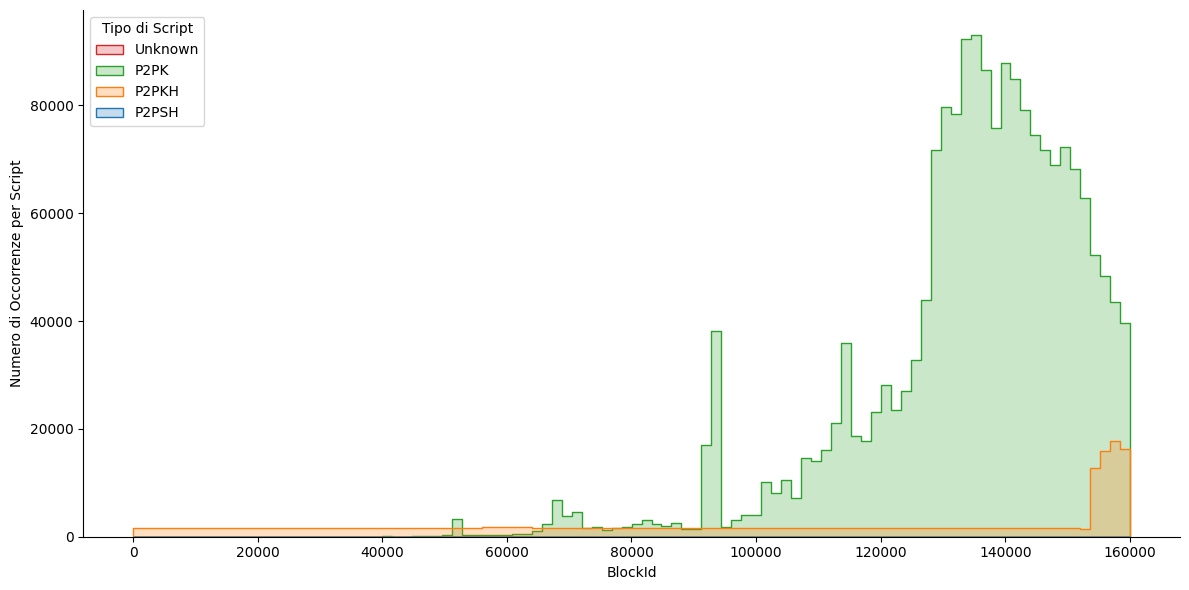

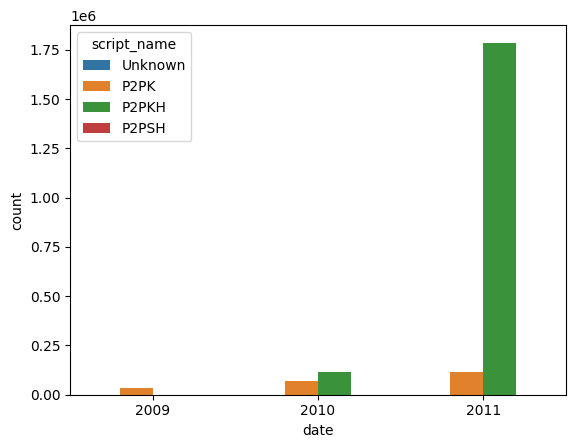

In [11]:
transactions['date'] = pd.to_datetime(transactions['timestamp'], unit='s')
# Filtro come da traccia per solo i primi 3 anni
print("Filtering the transactions for the first 3 years...")
start = transactions['date'].min() #Idealmente il primo 
end = start + pd.DateOffset(years=3) #3 anni dopo
end = '2012-01-01'  #La forzo altrimenti non mi prende il 1 gennaio

transactions_first_3_years = transactions[transactions['date'] < end] #Filtro per i primi 3 anni
print("Done...")
print(f"Currently working with {transactions_first_3_years.shape[0]} transactions...")
print("Merging the script type with the transactions...")
transactions_first_3_years.loc[:, 'txId'] = transactions_first_3_years['txId'].astype('int64')
outputs_script = outputs[['txId', 'scripttype']].drop_duplicates(subset="txId")
outputs_script.loc[:,'txId'] = outputs_script['txId'].astype('int64')
# Perform the merge operation
transactions_first_3_years = transactions_first_3_years.merge(
    outputs_script,
    on='txId',
    how='left'
)
print("Done...")
print("Mapping the script type to the script name...")
# Ora possiamo mappare il nome dello script al suo scripttype
transactions_first_3_years['script_name'] = transactions_first_3_years['scripttype'].map(script_name_map)
print("Done...")

print(transactions_first_3_years["script_name"].value_counts()) #Overview veloce di cosa troveremo

# Adesso possiamo pensare di usare un displolt per fare un istogramma della distribuzione dello script usato

data_grouped = transactions_first_3_years.groupby(['blockId', 'script_name'], observed=False).size().reset_index(name='count')
g = sns.displot(
    data=data_grouped, 
    x='blockId', 
    hue='script_name', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=False,
)
g.set_titles('Analisi della distribuzione nel tempo degli script usati nella blockchain nei primi 3 anni')
g.set_axis_labels('BlockId', 'Numero di Occorrenze per Script')
plt.legend(title='Tipo di Script', labels=['Unknown', 'P2PK', 'P2PKH', 'P2PSH'], loc='upper left')
plt.show()


# Barplot per vedere la distribuzione degli script usati anno per anno
grouped_by_year = transactions_first_3_years.groupby([transactions_first_3_years['date'].dt.year, 'script_name']).size().reset_index(name='count')
sns.barplot(data=grouped_by_year, x='date', y='count', hue='script_name')
plt.show()


Quello che notiamo dai grafici sopra, è che nel primo anno di vita della blockchain, l'unico script utilizzato era P2PK (inoltre notiamo che il quantitativo di transazioni è ben minore rispetto agli anni successivi).
Nei 2 anni successivi è entrato in utilizzo quasi esclusivamente P2PKH.
Questo ci suggerisce che la stra grande maggioranza degli utenti sulla blockchain ha preferito P2PKH rispetto a P2PK.
L'analisi ci torna coerente poiché P2PKH risulta più sicuro, esponendo l'hash della chiave pubblica piuttosto che la chiave pubblica stessa come avviene in P2PK.

Non ci sono occorrenze per P2PSH, il che ci suggerisce che per vederlo utilizzato dobbiamo espandere la finestra di riferimento, probabilmente oltre il 2012. 

Ci aspettavamo in realtà di vedere 14 unknown transaction type in questo periodo (e ci sono), ma da questa analisi, data la dispersione del dato e la sua esiguità, non si riescono a notare.

Ricordiamoci che le occorrenze di P2PSH e Unknown in questo dataset rimangono estremamente basse rispetto al resto. (65 occorrenze totali di P2PSH e 4849 occorrenze di Unknown)

## 3. Analisi delle Mining Pool

#### 3.1 Deanonimizzazione indirizzi di miningpool note 
Come richiesto dalla traccia, in questa fase dobbiamo:

1. Recuperare **tutti gli indirizzi** associati alle 4 principali Mining Pool attive nel periodo considerato:
   - Eligius
   - BTC Guild
   - BitMinter
   - DeepBit

2. Associare ogni indirizzo del nostro dataset ad una di queste mining pool, cercando di identificare a quale pool appartiene ogni indirizzo.

3. Se non riusciamo a deanonimizzare alcuni indirizzi, possiamo:
   - Utilizzare uno scraper ad-hoc per deanonimizzare indirizzi che non appartengono alle mining pool sopra elencate ma che sono comunque top miners, per risparmiare tempo.


### 3.1.1 Scraping degli indirizzi

In [40]:
import requests
from bs4 import BeautifulSoup
from fp.fp import FreeProxy #Random proxy generator per evitare di essere bloccati

active_mining_pools = ["Eligius.st", "BitMinter.com", "DeepBit.net", "BTCGuild.com"]


base_wallet_explorer_url = "http://www.walletexplorer.com/"
base_wallet_explorer_wallet_url = base_wallet_explorer_url + "wallet/"
# Ricordiamo che gli indirizzi sono in wallet/indirizzo/addresses

def custom_get_request(url, proxy=None):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    while True:
        try:
            # Usa il proxy se disponibile
            if proxy:
                response = requests.get(url, headers=headers, proxies={"http": proxy, "https": proxy})
            else:
                response = requests.get(url, headers=headers)
            
            # Se la risposta è 429, solleva un'eccezione per ritentare
            if response.status_code == 429:
                raise requests.exceptions.RequestException("HTTP 429 Too Many Requests")
            
            # Ritorna la risposta e il proxy usato se la richiesta ha successo
            return response, proxy
        
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}. Attempting to find a new proxy.")
            try:
                proxy = FreeProxy(rand=True, https=True).get()
                print(f"New proxy set: {proxy}")
            except:
                print("Failed to find a new proxy. Retrying without proxy.")
                proxy = None


def get_page_number(mining_pool):
    proxy = None
    # Faccio una singola richiesta di setup per ottenere il numero di pagine
    first_request = base_wallet_explorer_wallet_url + mining_pool + "/addresses"
    first_request, proxy = custom_get_request(first_request, proxy)
    soup = BeautifulSoup(first_request.text, 'html.parser')
    # Cerco il tag con la classe saveas tra i div (che contiene il numero di pagine, secondo un'analisi dal browser)
    page_number = soup.find_all('a', string='Last')
    if not page_number:
        return 1
    page_number = page_number[0].get('href').split('=')[1]
    
    return page_number

def extract_addresses(mining_pool, page_number):
    proxy = None
    # Estraggo tutti gli indirizzi di una pagina
    addresses = []
    print(f"Requesting all pages for {mining_pool}...")
    for page in tqdm(range(1, int(page_number) + 1), desc="Processing pages"):
        request = base_wallet_explorer_wallet_url + mining_pool + "/addresses?page=" + str(page)
        request, proxy = custom_get_request(request, proxy)
        soup = BeautifulSoup(request.text, 'html.parser')
        # Prendo la tabella degli indirizzi
        full_table = soup.find_all('table')[0]
        # Prendo tutte le righe della tabella
        rows = full_table.find_all('tr')
        rows.pop(0) #Rimuovo la prima riga che è l'header
        # Ora posso estrarre gli indirizzi
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            addresses.append(cols[0])
        
    return addresses

address_dictionary = {}        
for mining_pool in active_mining_pools:
    print(f"Requesting page number for {mining_pool}...")
    # Faccio una singola richiesta di setup per ottenere il numero di pagine
    page_number = get_page_number(mining_pool)
    # Ora che ho il numero pagina posso scrivere uno script che prenda tutti quanti gli indirizzi in una pagina :)
    print(f"Extracting addresses for {mining_pool}...")
    addresses = extract_addresses(mining_pool, page_number)    
    address_dictionary[mining_pool] = pd.Series(addresses) #Creo una serie per poterci fare poi operazioni efficienti nel caso serva
    print(f"Extracted {len(addresses)} addresses for {mining_pool}...")
    
#printa le len di ogni key
for key in address_dictionary.keys():
    print(f"Addresses for {key}: {len(address_dictionary[key])}")   


Requesting page number for Eligius.st...
Extracting addresses for Eligius.st...
Requesting all pages for Eligius.st...


Processing pages: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


Extracted 1033 addresses for Eligius.st...
Requesting page number for BitMinter.com...
Extracting addresses for BitMinter.com...
Requesting all pages for BitMinter.com...


Processing pages: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Extracted 440 addresses for BitMinter.com...
Requesting page number for DeepBit.net...
Extracting addresses for DeepBit.net...
Requesting all pages for DeepBit.net...


Processing pages: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Extracted 2 addresses for DeepBit.net...
Requesting page number for BTCGuild.com...
Extracting addresses for BTCGuild.com...
Requesting all pages for BTCGuild.com...


Processing pages:   0%|          | 0/79 [00:00<?, ?it/s]

Request failed: HTTP 429 Too Many Requests. Attempting to find a new proxy.
New proxy set: http://195.62.32.117:22331


Processing pages: 100%|██████████| 79/79 [03:30<00:00,  2.67s/it] 

Extracted 7865 addresses for BTCGuild.com...
Addresses for Eligius.st: 1033
Addresses for BitMinter.com: 440
Addresses for DeepBit.net: 2
Addresses for BTCGuild.com: 7865


Qui ho analizzato le pagine a cui dovevo fare richiesta, su walletexplorer e dopo l'analisi ho scritto questo scraper che per prima cosa capisce quante pagine di indirizzi dovrà scrapare per ogni miningpool, e, successivamente, richiede tutte le pagine necessarie, scrapando dalla tabella gli indirizzi ed aggiungendoli ad una lista. Alla fine ho un dict dove le key sono le miningpool e i valori sono pd.Series con all'interno tutti gli indirizzi associati a quella miningpool.

Una cosa che si è rivelata importantissima è stata l'uso dei proxy, poichè dopo tot richieste, walletexplorer blocca le richieste dall'ip per tot tempo.
Per ovviare a ciò, ho usato dei proxy gratutiti restituiti da FreeProxy, che ho aggiunto nella richiesta GET di requests, scrivendo poi una funzione ad-hoc che in caso di blocco, cambia automaticamente il proxy e riprova la richiesta

### 3.2.1: Deanonimizzazione indirizzi di MiningPool note usando i dati scrapati da WalletExplorer
Per questa operazione, innanzitutto ci concentriamo solo su transazioni di tipo coinbase, poichè non siamo interessati alle semplici transazioni tra utenti della blockchain, almeno per ora. Per associare una miningpool ad ogni transazioni coinbase, non ci basta che filtrarle e poi chiederci se l'indirizzo è in uno delle series all'interno del dizionario che abbiamo creato prima

In [13]:
only_coinbase = transactions[transactions['isCoinbase'] == 1]
print(f"Number of coinbase transactions: {only_coinbase.shape[0]}")
# Ora associamo queste transazioni agli output (che contengono gli addressId)
print("Merging the coinbase transactions with the outputs...")
only_coinbase = only_coinbase.merge(outputs[['txId','addressId']].astype("int64"), on='txId', how='left') #Questa volta non cancello i duplicati perchè mi servono potenzialmente
print("Done...")
# Ora posso associare gli addressId con gli hash
print("Merging the addressId with the hash...")
only_coinbase = only_coinbase.merge(mapping, on='addressId', how='left')
print("Done...")
print("Mapping the hash (the addresse of the wallet) to the mining pool...")
# Converto address_dictionary in un mapping di hash a mining pool
hash_to_pool = {}
for pool_name, series in address_dictionary.items():
    for hash_value in series:
        hash_to_pool[hash_value] = pool_name

only_coinbase['mining_pool'] = only_coinbase['hash'].map(hash_to_pool)
#only_coinbase['mining_pool'] = only_coinbase['mining_pool'].fillna("Others") #Se non trovo il mining pool, lo metto come unknown
print(only_coinbase['mining_pool'].value_counts())
print("Done...")

Number of coinbase transactions: 214559
Merging the coinbase transactions with the outputs...
Done...
Merging the addressId with the hash...
Done...
Mapping the hash (the addresse of the wallet) to the mining pool...
mining_pool
BitMinter.com    2024
Eligius.st       1439
BTCGuild.com     1162
Name: count, dtype: int64
Done...


A questo punto siamo riusciti a deanonimizzare un totale di 4625 transazioni. Ne mancano all'appello circa 200000.
Quello che faremo ora, è andare a cercare i top 4 miners che hanno prodotto più coinbase transactions e deanonimizzarli singolarmente facendo richiesta a WalletExplorer.

In [14]:
# Top 4 miners
# Siccome ho già associato gli hash alle transactions, mi basta semplicemente grouppare per hash e contare quante transactions ci sono per ognuno di loro e prendere i 4 più grandi. Il risultato non è altro che i top 4 miners
print("Computing the top 4 miners...")
top_4_miners = only_coinbase.groupby('hash').size().nlargest(4).index
print("Done...")
print(top_4_miners)

Computing the top 4 miners...
Done...
Index(['1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm',
       '19PkHafEN18mquJ9ChwZt5YEFoCdPP5vYB',
       '1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9',
       '1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy'],
      dtype='object', name='hash')


### 3.2.2. Deanonimizzazione dei top 4 miners
Prima di tutto di questi top 4 miners, capiamo quali ho già identificato (se li ho identificati).
Di quelli ancora anonimi, mi basta fare richiesta a WalletExplorer, in maniera similare a come ho fatto prima, circa, per recuperarne, se c'è, la MiningPool di appartenenza

In [15]:
# Filtro per quelli che hanno mining_pool Unknown
print("Filtering for the unknown mining pools in the top 4 miners...")
# Copia per l'operazione 
known_addresses_mining_pool = only_coinbase[~only_coinbase['mining_pool'].isnull()]

top_4_miners = top_4_miners[~ top_4_miners.isin(known_addresses_mining_pool['hash'])]
print("Remaining ", top_4_miners.shape[0], " miners...")
print(top_4_miners)

Filtering for the unknown mining pools in the top 4 miners...
Remaining  3  miners...
Index(['1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm',
       '1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9',
       '1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy'],
      dtype='object', name='hash')


Come vediamo un indirizzo dei top 4 miners l'avevamo già deanonimizzato, dunque è stato filtrato. Adesso scriviamo lo scraper per recuperare quello che è il wallet associato a questi miners.
Quello che ho deciso di fare è leggermente più elaborato e mi porterà, sperabilmente, ad avere più indirizzi deanonimizzati. Per farlo, invece che annotare semplicemente i 3 indirizzi rimasti, annoterò tutti gli indizzi associati ai wallet a cui fanno parte i top miners.

In [16]:
# Trovato tra le richieste fatte per gli indirizzi singolari
#  https://www.walletexplorer.com/?q={ADDRESS}

def get_mining_pool_from_address(address_hash):
    proxy = None
    base_wallet_explorer_url = "https://www.walletexplorer.com/?q="
    # Faccio una singola richiesta di setup per ottenere il numero di pagine
    request_url = base_wallet_explorer_url + address_hash
    first_request, proxy = custom_get_request(request_url, proxy)
    soup = BeautifulSoup(first_request.text, 'html.parser')
    # Cerco l'a con text 'show wallet addresses'
    a_wallet = soup.find_all('a', string='show wallet addresses')
    if not a_wallet:
        return "Others"
    
    return a_wallet[0]['href'].split('/')[2]

top_4_miners_mining_pool = {}
print("Getting the mining pools of the 3 top miners remaining...")
for miner in top_4_miners:
    top_4_miners_mining_pool[get_mining_pool_from_address(miner)] = pd.Series()

print("Done...")
print("Retrieving all the addresses associated with the mining pools newly finded...")
for mining_pool in top_4_miners_mining_pool.keys():
    print(f"Requesting page number for {mining_pool}...")
    # Faccio una singola richiesta di setup per ottenere il numero di pagine
    page_number = get_page_number(mining_pool)
    # Ora che ho il numero pagina posso scrivere uno script che prenda tutti quanti gli indirizzi in una pagina :)
    print(f"Extracting addresses for {mining_pool}...")
    addresses = extract_addresses(mining_pool, page_number)    
    top_4_miners_mining_pool[mining_pool] = pd.Series(addresses) #Creo una serie per poterci fare poi operazioni efficienti nel caso serva
    print(f"Extracted {len(addresses)} addresses for {mining_pool}...")
print("Done...")
print("Mapping the hash (the addresse of the wallet) to the mining pool...")
# Convert address_dictionary to a mapping of hash to mining pool
hash_to_pool_new = {}
for pool_name, series in top_4_miners_mining_pool.items():
    for hash_value in series:
        hash_to_pool_new[hash_value] = pool_name
print("Done...")
print("Creating a temporary column to merge the two mining pools...")
only_coinbase['mining_pool_2'] = only_coinbase['hash'].map(hash_to_pool_new)
# Faccio una veloce operazione per mergiare le due 
print("Merging the two mining pools...")
only_coinbase['mining_pool'] = only_coinbase.apply(lambda row: row["mining_pool_2"] if pd.isna(row["mining_pool"]) else row["mining_pool"], axis=1)
only_coinbase['mining_pool'] = only_coinbase['mining_pool'].fillna("Others") #Se non trovo il mining pool, lo metto come unknown
print("Done...")

Getting the mining pools of the 3 top miners remaining...
Done...
Retrieving all the addresses associated with the mining pools newly finded...
Requesting page number for 3e486bf1d3615fb8...
Extracting addresses for 3e486bf1d3615fb8...
Requesting all pages for 3e486bf1d3615fb8...


Processing pages: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Extracted 3 addresses for 3e486bf1d3615fb8...
Requesting page number for EclipseMC.com-old...
Extracting addresses for EclipseMC.com-old...
Requesting all pages for EclipseMC.com-old...


Processing pages: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Extracted 588 addresses for EclipseMC.com-old...
Requesting page number for 019a46b8d84bf5b5...
Extracting addresses for 019a46b8d84bf5b5...
Requesting all pages for 019a46b8d84bf5b5...


Processing pages: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Extracted 241 addresses for 019a46b8d84bf5b5...
Done...
Mapping the hash (the addresse of the wallet) to the mining pool...
Done...
Creating a temporary column to merge the two mining pools...
Merging the two mining pools...
Done...


In [17]:
only_coinbase['mining_pool'].value_counts()

mining_pool
Others               497729
3e486bf1d3615fb8       2769
BitMinter.com          2024
EclipseMC.com-old      1919
019a46b8d84bf5b5       1754
Eligius.st             1439
BTCGuild.com           1162
Name: count, dtype: int64

Seguendo questa pipeline, siamo riusciti a deanonimizzare tantissime altre transazioni aggiuntive che sicuramente possono farci comodo nelle analisi.

### 3.3. Analisi statistiche sulle coinbase deanonimizzate
Continuiamo ad effettuare delle analisi. In questo caso, tra le transazioni coinbase delle 4 miningpools indicateci prima, mostriamo l'andamento globale e per intervalli di 2 mesi dei blocchi minati. Poi lo rifacciamo per i top 4 miners.
In fine aggiungerò la stessa analisi ma con tutti quanti gli indirizzi deanonimizzati da me, appartenenti alle mining pools dei top 4 miners.

In [18]:
# Mining pools considerate 
considered_mining_pools = ["Eligius.st", "BitMinter.com", "DeepBit.net", "BTCGuild.com"] #Rimuovo anche others altrimenti le analisi non si riescono a fare ad occhio nudo
# Filtro per i mining pools considerati
print("Filtering for the considered mining pools...")
only_coinbase_4_given_pools = only_coinbase[only_coinbase['mining_pool'].isin(considered_mining_pools)]
print("Done...")
print(only_coinbase_4_given_pools['mining_pool'].value_counts())

Filtering for the considered mining pools...
Done...
mining_pool
BitMinter.com    2024
Eligius.st       1439
BTCGuild.com     1162
Name: count, dtype: int64


##### 3.3.1 Analisi blocchi minati top 4 mining pools dell'epoca
Andiamo a vedere l'andamento globale del mining di queste 3 mining pools.

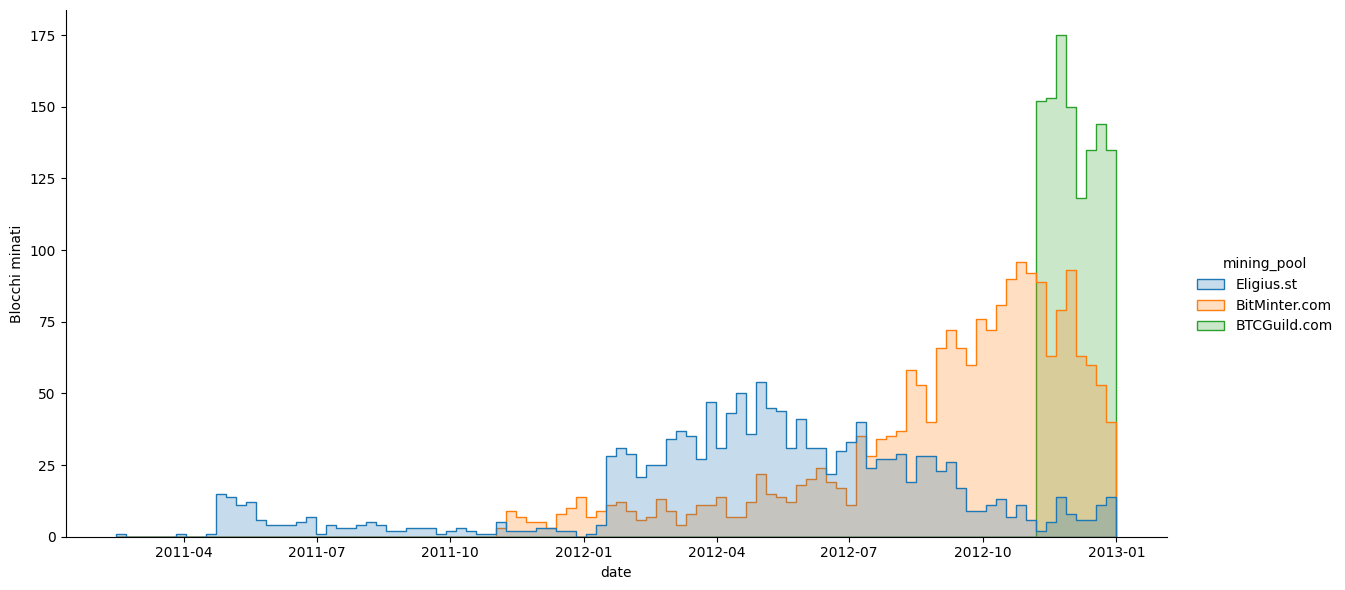

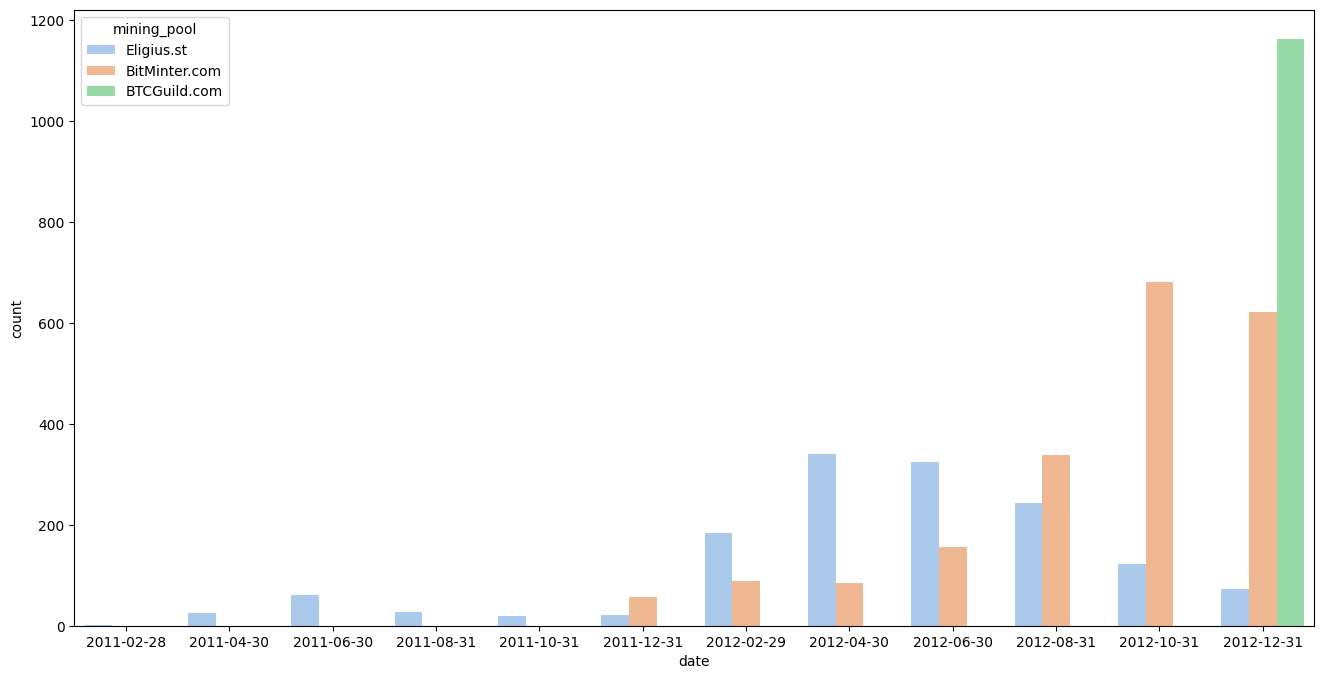

In [19]:
grouped = only_coinbase_4_given_pools.groupby(['date','blockId', 'mining_pool']).size().reset_index(name='count')
g = sns.displot(
    data=grouped, 
    x='date', 
    hue='mining_pool', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend="auto",
)
g.set_titles('Analisi della distribuzione nel tempo dei mining pools nelle transazioni coinbase')
g.set_axis_labels('date', 'Blocchi minati')
#plt.legend(title='Mining Pool', labels=["Eligius.st","BitMinter.com", "BTCGuild.com"], loc='upper left')
plt.show()

#Ripetiamo intervallando di 2 mesi il groupby
grouped = only_coinbase_4_given_pools.groupby([
    pd.Grouper(key='date', freq='2M'),  # Qui vado ad usare pd.Grouper che sulle date mi fa in automatico il groupby per intervallo (2 mesi in questo caso)
    'blockId', 
    'mining_pool'
]).size().reset_index(name='count') 
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=grouped, 
    x='date', 
    y='count',
    hue='mining_pool', 
    errorbar=None,
    legend="auto",
    estimator=sum,
    palette="pastel"
    
)
#g.set_titles('Analisi della distribuzione nel tempo dei mining pools nelle transazioni coinbase con intervalli di due mesi')
#g.set_axis_labels('date', 'Blocchi minati')
plt.show()

Analizziamo i risultati di questi due grafici.
Entrambi ci forniscono tendenzialmente la stessa analisi. Le Mining Pool che stiamo considerando, secondo questo dataset, sono state attive tendenzialmente a partire dal 2011.
Nella prima (dove l'analisi è globale) vediamo che all'inizio Eligius è l'unica mining pool attiva tra le 4 (3, DeepMint non ha indirizzi in questo dataset). Poi da fine 2011 inizia ad essere attiva anche BitMinter e verso la fine del 2012 vengono tutte sorpassate da BTCGuild.
Il secondo grafico, che invece raggruppa in gruppi di due mesi i blocchi minati, ci conferma tendenzialmente la stessa analisi. All'inizio è presente solo Eligius, poi si aggiunge BitMinter, in maniera molto aggressiva. E poi diventa attiva BTCGuild che le sorpassa entrambe.

Segnalo la necessità di aver rimosso le "Others" da questo studio, altrimenti i grafici sarebbero stati totalmente schiacciati dalla suddetta categoria, non consentendo una visione così chiara.

Dato che li ho annotati, proviamo a rimuovere "Others" ma a mantenere le mining pools dei top 4 scorer (per la quale poi farò un'analisi separata)

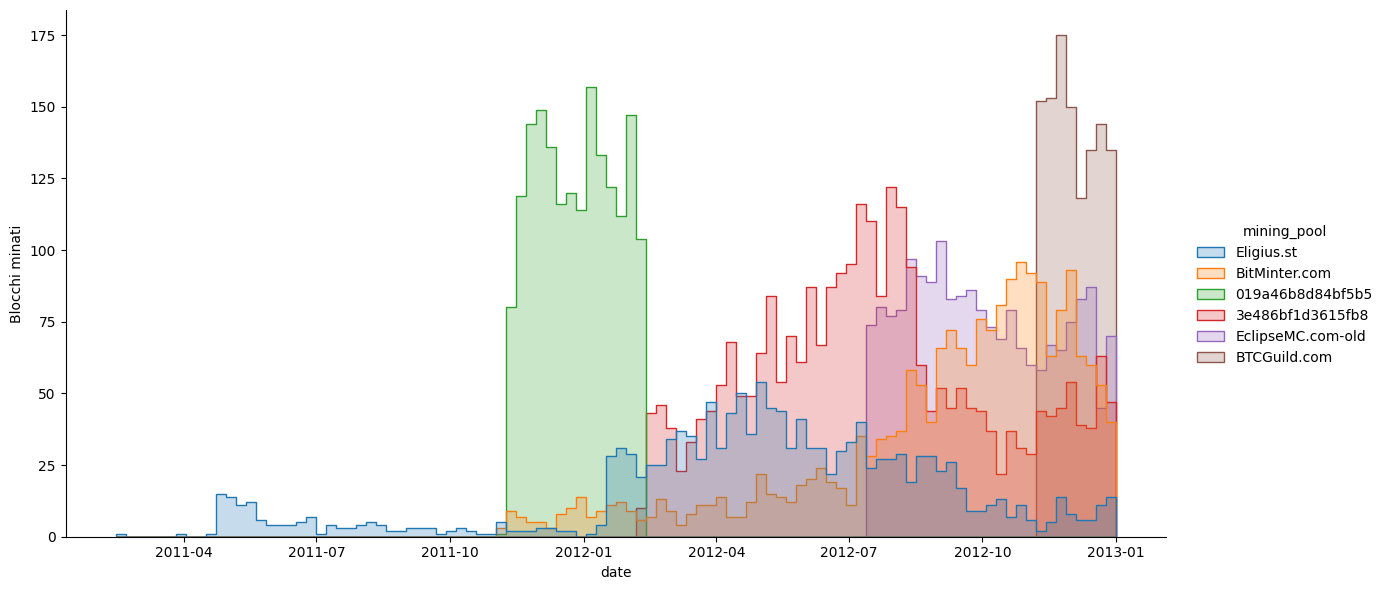

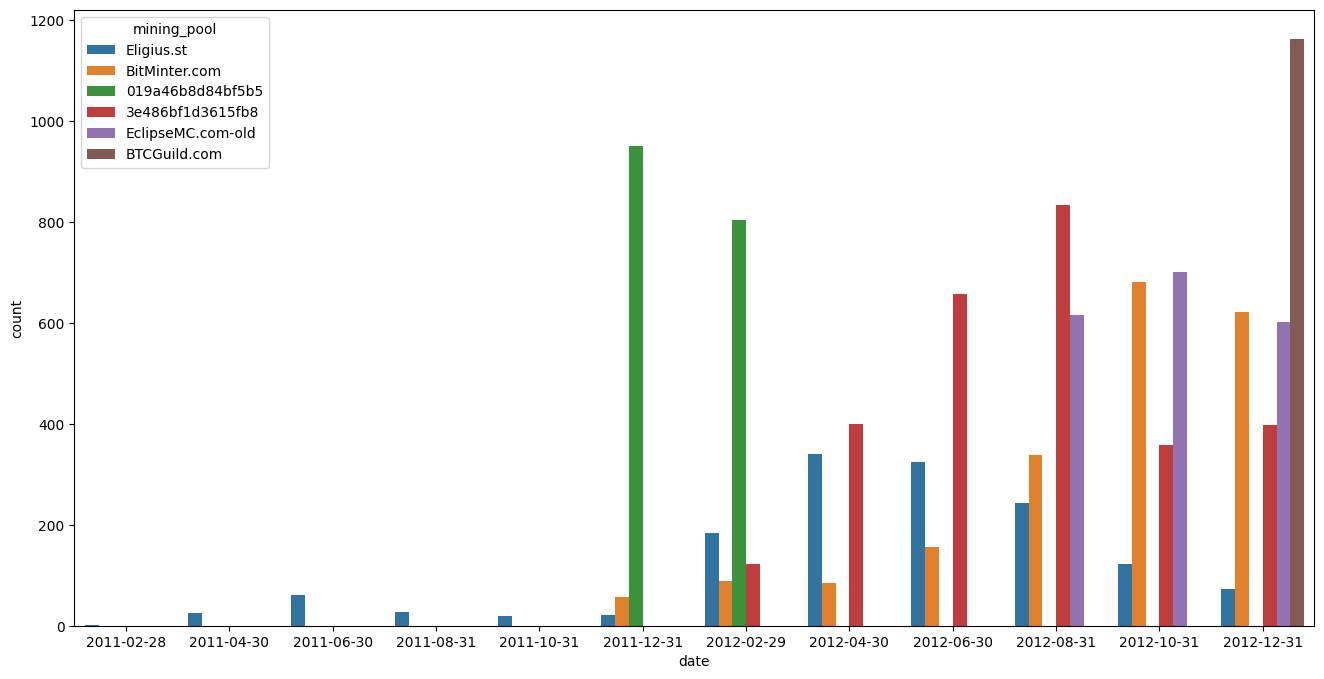

In [20]:
all_except_others = only_coinbase[only_coinbase['mining_pool'] != "Others"]
grouped = all_except_others.groupby(['date','blockId', 'mining_pool']).size().reset_index(name='count')
g = sns.displot(
    data=grouped, 
    x='date', 
    hue='mining_pool', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=True,
)
g.set_titles('Analisi della distribuzione nel tempo dei mining pools nelle transazioni coinbase includendo altre mining pools')
g.set_axis_labels('date', 'Blocchi minati')
plt.show()
grouped = all_except_others.groupby([
    pd.Grouper(key='date', freq='2M'),  # Qui vado ad usare pd.Grouper che sulle date mi fa in automatico il groupby per intervallo (2 mesi in questo caso)
    'blockId', 
    'mining_pool'
]).size().reset_index(name='count') 
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=grouped, 
    x='date', 
    y='count',
    hue='mining_pool', 
    errorbar=None,
    legend="auto",
    estimator=sum,    
)

Questa analisi è molto interessante, poiché ci mostra come a partire dal 2012, il numero di concorrenti in mining era notevolmente più alto.
Tra le particolarità, notiamo come Eligius.st, seppur in minoranza rispetto ad altri, sia presente per praticamente tutta la storia iniziale della blockchain.
"019a46b8d84bf5b5" che è una mining pool a cui appartiene un top 4 miner, ha avuto 4 mesi di altissima produttività, che si è poi totalmente arrestata.
"3e486bf1d36515fb8", un'altra delle mining pool che ho aggiunto io, è attiva dal bimestre 2012-02/2012-04 in poi e risulta rimanere una delle più attive man mano.
L'altra aggiunta è EclipseMC.com che dal 2012-04 ha una presenza importante in questa analisi.

Ancora una volta, il numero di transazioni a cui ho associato "Others" è troppo, troppo alto per considerarlo nell'analisi, dunque, resta fuori, altrimenti come detto prima, annichilirebbe i risultati

##### 3.3.2. Analisi per top 4 miners
Ripetiamo l'analisi per i top 4 miners

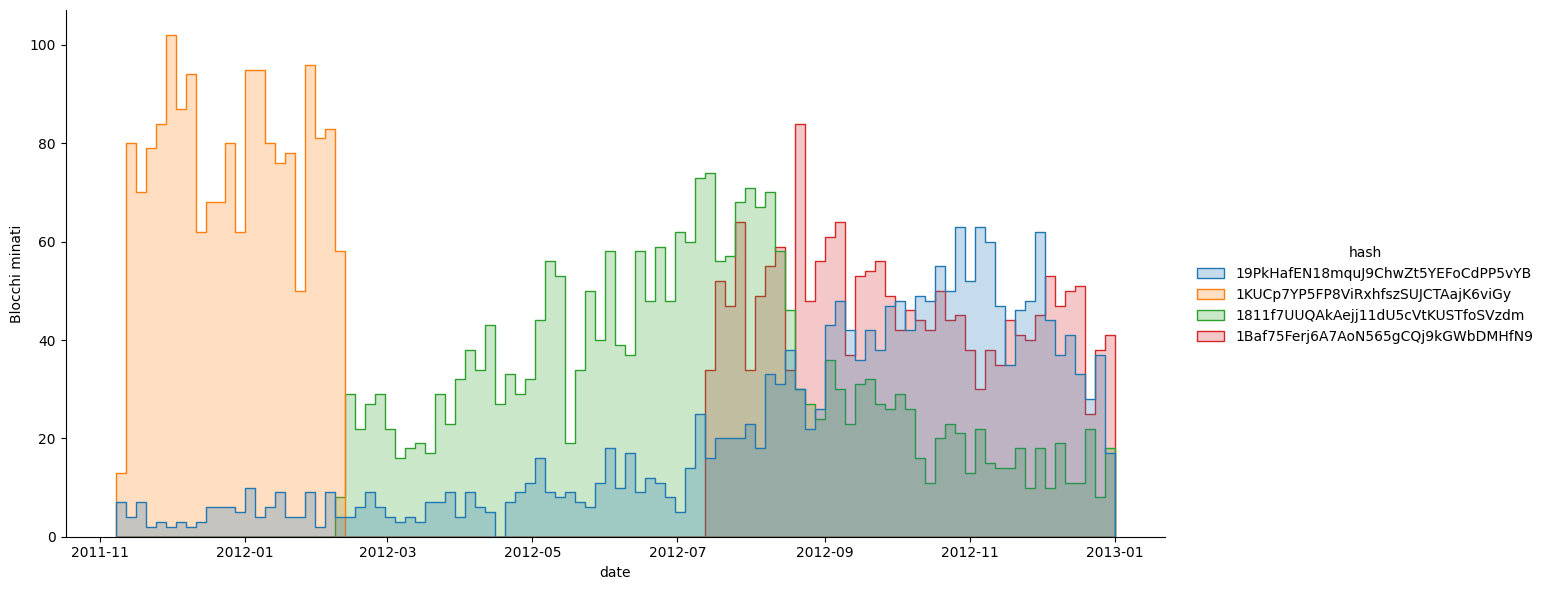

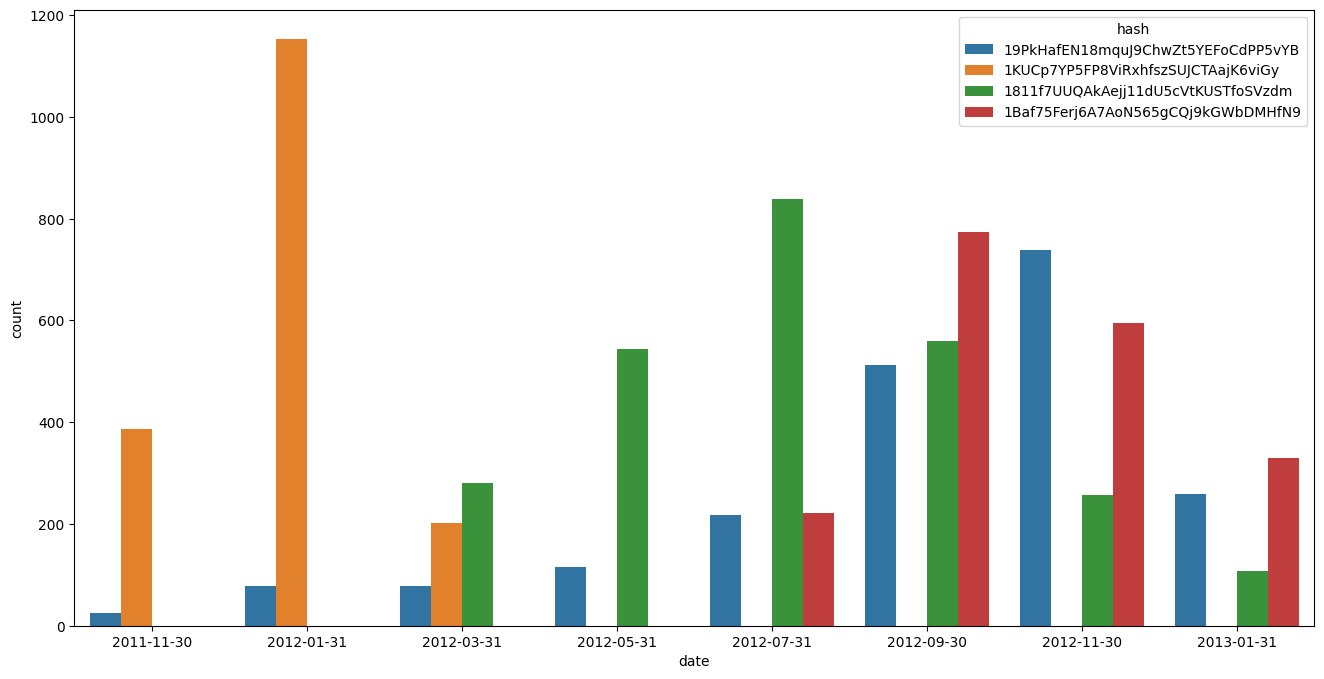

Belongings of the top 4 miners
['BitMinter.com' '019a46b8d84bf5b5' '3e486bf1d3615fb8' 'EclipseMC.com-old']


In [21]:
top_4_miners = only_coinbase.groupby('hash').size().nlargest(4)
only_top_4_miners = only_coinbase[only_coinbase['hash'].isin(top_4_miners.index)]
grouped = only_top_4_miners.groupby(['date','blockId', 'hash']).size().reset_index(name='count')
g = sns.displot(
    data=grouped, 
    x='date', 
    hue='hash', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=True,
)
g.set_titles('Analisi blocchi minati dai top 4 miners')
g.set_axis_labels('date', 'Blocchi minati')
plt.show()
grouped = only_top_4_miners.groupby([
    pd.Grouper(key='date', freq='2M'),  # Qui vado ad usare pd.Grouper che sulle date mi fa in automatico il groupby per intervallo (2 mesi in questo caso)
    'blockId', 
    'hash'
]).size().reset_index(name='count') 
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=grouped, 
    x='date', 
    y='count',
    hue='hash', 
    errorbar=None,
    legend="auto",
    estimator=sum,    
)
plt.show()
print("Belongings of the top 4 miners")
print(only_top_4_miners['mining_pool'].unique())

Quello che vediamo è che ad esempio, l'indirizzo in arancione è stato attivo solamente per i primi 6 mesi disponibili, mentre quello in rosso per gli ultimi 8 mesi disponibili.
L'indirizzo in verde e quello in blu tuttavia, hanno portato avanti la loro presenza per buona parte della vita della blockchain in questo spezzone.
In particolare il miner blu è sempre stato attivo e nel tempo ha avuto picchi abbastanza importanti come miner.

#### 3.4. Distribuzione dei reward totali ottenuti dalle mining pool. 
Per capire quali sono stati i reward totali, dobbiamo prima analizzare gli outputs, mergiandoli alle transazioni coinbase. Dopo di che grouppando potremo continuare l'analisi

Number of coinbase transactions: 508796
Merging the coinbase transactions with the outputs...
Done...
Computing the total amount of rewards for the mining pools we've discovered...
mining_pool
3e486bf1d3615fb8     133188.614952
BitMinter.com         94132.813132
019a46b8d84bf5b5      87786.867324
EclipseMC.com-old     87727.779839
Eligius.st            70919.327266
BTCGuild.com          42036.491458
Name: amount, dtype: float64
Done...


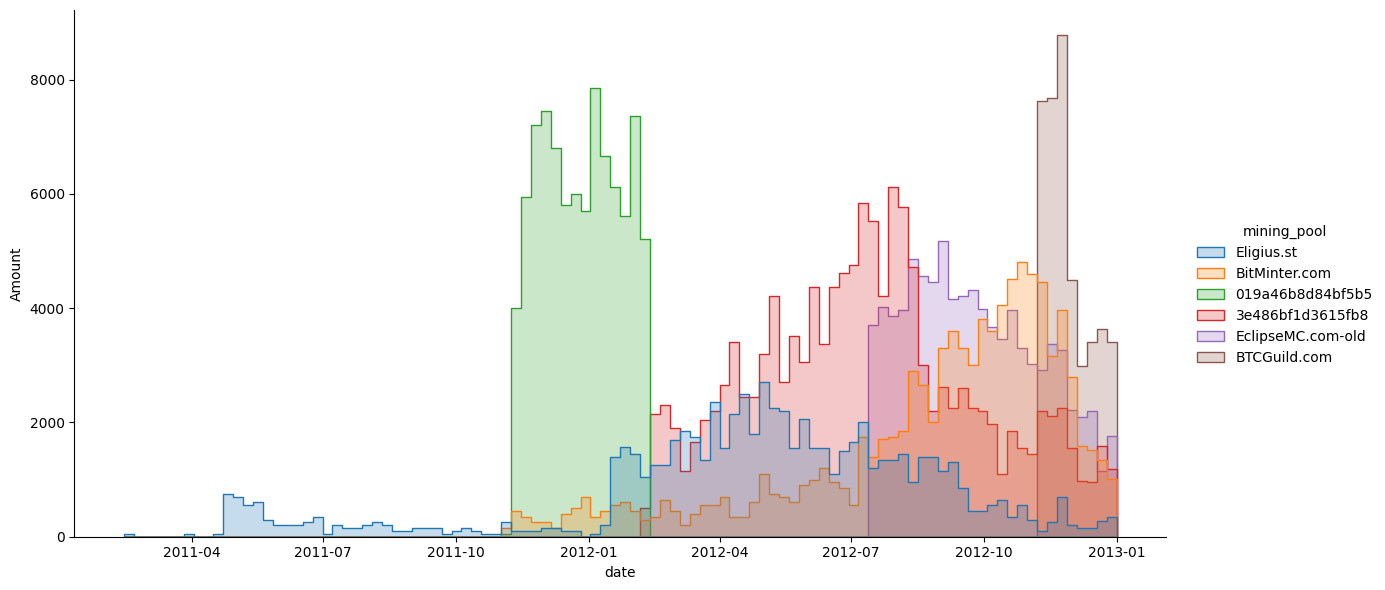

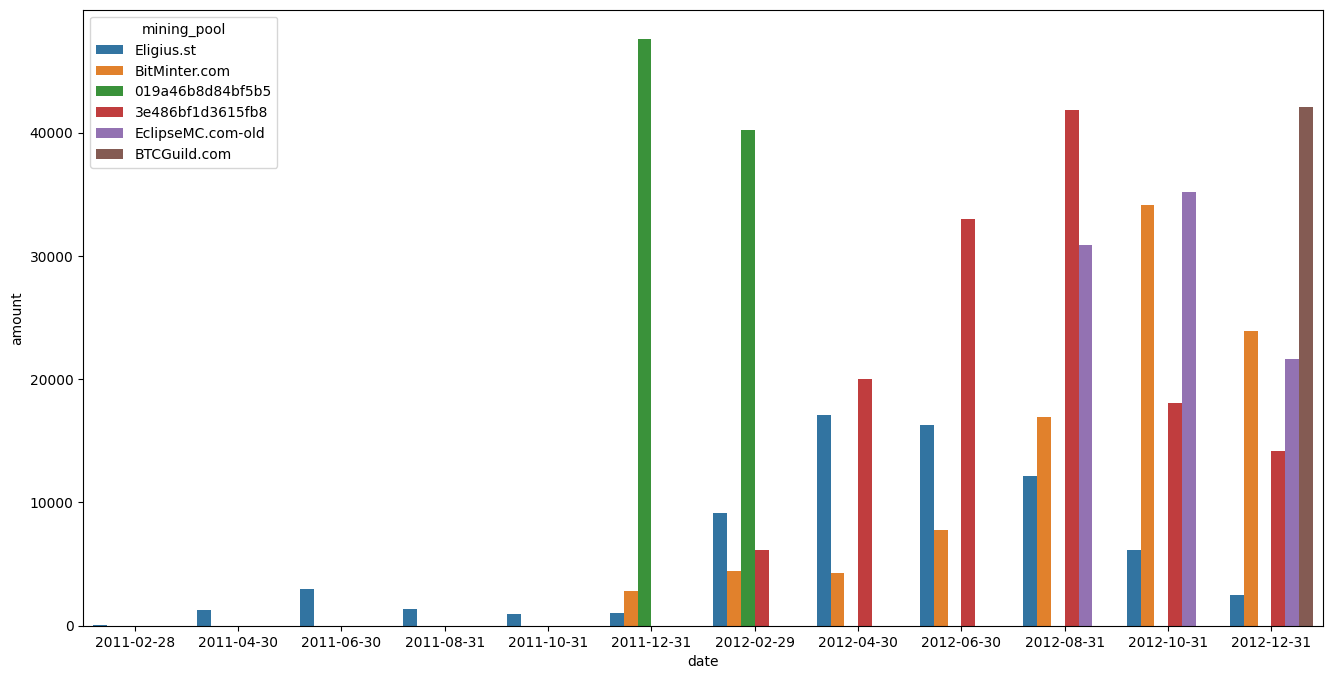

In [22]:
# Copio only_coinbase per fare le operazioni di merge
only_coinbase_copy = only_coinbase.copy()
print(f"Number of coinbase transactions: {only_coinbase_copy.shape[0]}")
# Ora associamo queste transazioni agli output (che contengono gli amount)
print("Merging the coinbase transactions with the outputs...")
only_coinbase_copy = only_coinbase_copy.merge(outputs.astype("int64"), on='txId', how='left') #Questa volta non cancello i duplicati perchè mi servono potenzialmente
print("Done...")

# Adesso plotto la distribuzione degli amount per le 4 mining pools, tolgo others perchè non mi interessa
only_coinbase_no_others = only_coinbase_copy[only_coinbase_copy['mining_pool'] != "Others"]
grouped = only_coinbase_no_others.groupby(['date','blockId', 'mining_pool'])['amount'].sum().reset_index()
grouped['amount'] = grouped['amount'] / 100000000 # Operazione per convertire i satoshi in bitcoin
print("Computing the total amount of rewards for the mining pools we've discovered...")
print(grouped.groupby('mining_pool')['amount'].sum().sort_values(ascending=False))
print("Done...")


g = sns.displot(
    data=grouped, 
    x='date', 
    weights='amount',
    hue='mining_pool', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=True,
)
g.set_titles('Analisi della distribuzione nel tempo dei rewards ottenuti dalle mining pool')
g.set_axis_labels('date', 'Amount')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


grouped = only_coinbase_no_others.groupby([
    pd.Grouper(key='date', freq='2M'),  # Qui vado ad usare pd.Grouper che sulle date mi fa in automatico il groupby per intervallo (2 mesi in questo caso)
    'blockId', 
    'mining_pool'
])['amount'].sum().reset_index()
grouped['amount'] = grouped['amount'] / 100000000 # Operazione per convertire i satoshi in bitcoin
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=grouped, 
    x='date', 
    y='amount',
    hue='mining_pool', 
    errorbar=None,
    legend="auto",
    estimator=sum,    
)

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Dall'analisi sovrastante, si evince che la top earner mining pool in assoluto tra quelle che ho deanonimizzato è '3e486bf1d3615fb8', con un totale di 133188.614952 BTC minati nell'arco temporale considerato da questo dataset, mentre, tra le 4 proposte dalla traccia, la top earner è BitMinter.
Un'analisi ovvia, è che comparandoli ai grafici dell'analisi fatta prima, tendenzialmente i periodi con un numero di blocchi minati maggiore per ogni mining pool, corrisponde anche ai periodi in cui quella mining pool ha guadagnato di più. Dunque i reward ottenuti da una mining pool nel tempo, come ci aspettavamo, seguono il numero di blocchi che la mining pool riesce a minare.

Una cosa interessante, è che gli earnings pubblicati da BitMinter prima della chiusura (https://bitminter.com/shutdown.html) sono 208232 BTC (tendenzialmente l'1% dei btc in circolo ad oggi), contro i 94132 trovati da noi. Questo significa che c'è una buona parte del periodo di mining di BitMinter che questo dataset non copre.

Curiosissimo il fatto che nel 2014, BitMinter coprisse il 10% della potenza computazionale totale della blockchain di BTC, un fatto incredibile che grosso modo ci dimostra che all'epoca il sistema di Proof Of Work poteva essere effettivamente aggirato. Ipotizzando che le maggiori mining pool si fosserò unite, superando il 51% della potenza computazionale a servizio della blockchain, avrebbero potuto approvare transazioni invalide. (Qui parliamo quasi di fantascienza poichè un attacco del 51% è praticamente insostenibile, soprattutto ad oggi ma anche all'epoca.)
Alcune preoccupazioni riguardo un 51% attack sono esposte dai creatori di Eligius a questo [indirizzo](https://ocean.xyz/about)

### 4.0. Taint Analysis
Quello che andremo a fare in questa fase, è cercare di ricostruire il flusso generato dai bitcoin ottenuti come reward dalla mining pool Eligius.st con questa transazione [c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6...](https://www.walletexplorer.com/txid/c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6?from_txid_start=c82c10925cc3890f1299), nel 2011, per aver minato il blocco 118869.
Vediamo che, come ci aspettiamo, essendo una transazione coinbase, non ha input, ma ha come output (amount 50BTC, al cambio oggi 2675694 EUR) un indirizzo appartenente alla mining pool Eligius.st. 
Con dello scraping, andremo a seguirne il percorso fino a profondità K (idealmente vorrei provare ad arrivare ad oggi, ma non sarà possibile) e man mano costruiremo un grafo che descriva il percorso. Quello che ci aspettiamo è che venga creato un piccolo network.


##### 4.1 Creare lo scraper di una pagina relativa ad una transaction
Lo scraper idealmente dovrà darmi il txId, gli input, gli output ed il loro corrispettivi amount e address.

In [23]:
def scrape_transaction(txId):
    base_url = "http://www.walletexplorer.com/txid/"
    request_url = base_url + str(txId)
    proxy = None
    request, proxy = custom_get_request(request_url, proxy)
    soup = BeautifulSoup(request.text, 'html.parser')
    
    return_info = {}
    # Da table info entro nel tbody
    
    # Accesso alle informazioni
    txid = soup.find('th', string='Txid').find_next_sibling('td').text
    block_info = soup.find('th', string='Included in block').find_next_sibling('td').text.split(' ')[0]
    time = soup.find('th', string='Time').find_next_sibling('td').text
    size = soup.find('th', string='Size').find_next_sibling('td').text
    
    return_info['txId'] = txid
    return_info['block'] = block_info
    return_info['date'] = time
    return_info['size'] = size
    
    # Ora andiamo a cercare gli input e gli output (gli input potrebbero, come nel caso della prima tx, una coinbase, non esserci. Poi potrebbero essere molteplici e avere molteplici output)
    # Estrazione degli input e output
    inputs = []
    outputs = []
    
    # Andiamo a prendere le due table di class empty (che contengono gli input e gli output)
    in_outs = soup.find_all('table', class_='empty')
    ins = in_outs[0]
    outs = in_outs[1]
    # Estrazione degli input
    ins = ins.find_all("tr")
    # Controllo che non sia una coinbase
    coinbase = ins[0].find_all("td")[0].find_all("em") != []
    
    return_info['coinbase'] = coinbase
    
    # Se è una coinbase lasciamo inputs vuoto, altrimenti ora possiamo estrarre gli input
    if not coinbase: #not
        for in_out in ins:
            in_outs_tr = in_out.find_all("td")
            non_standard = in_outs_tr[0].find_all("a") == []
            if non_standard:
                continue
            from_address = in_outs_tr[0].find_all("a")[0]['href'].split('/')[2]
            amount = float(in_outs_tr[1].text.split(" ")[0])
            # Io qui sto ignorando la source transaction poichè altrimenti diventerebbe un lavoro di backtracking troppo lungo, ma in teoria potrei farlo 
            inputs.append({"from_address":from_address, "amount":amount})
        return_info['inputs'] = inputs

    # A prescindere dal se è coinbase o no, di sicuro ci interessano gli outputs e quindi andiamo a prendere quelli
    for out in outs:
        out_tr = out.find_all("td")
        # Può capitare che il to_address sia not-address (non standard) quindi serve un controllo
        non_standard = out_tr[0].find_all("a") == []
        if non_standard:
            continue
        to_address = out_tr[0].find_all("a")[0]['href'].split('/')[2]
        wallet = out_tr[1].text
        if wallet == '(change address)':
            wallet = None
        else:
            wallet = wallet.replace('[','').replace(']','')
        amount = float(out_tr[2].text.split(" ")[0])
        # Controlliamo che non sia unspent (siamo arrivati al capolinea)
        unspent = out_tr[3].text == "unspent"
        if unspent: 
            out_transaction = None
        else: 
            out_transaction = out_tr[3].find_all("a")[0]['href'].split('/')[2]
        outputs.append({"to_address":to_address, "wallet":wallet, "amount":amount, "out_transaction":out_transaction})
    return_info['outputs'] = outputs
    
    
    return return_info
        
    
# Test :)))
print(scrape_transaction("c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"))
print(scrape_transaction('126b8fd8200800c5ec2e2148bf9fecd80f73c46076c5c6577e1f63cf039670b6'))
print(scrape_transaction('b6e8b63fc7a720ceed2deb4d2241701f14a8cbaa04bfb4ac2c2de2b5f9a0ed99'))
print(scrape_transaction('cee16a9b222f636cd27d734da0a131cee5dd7a1d09cb5f14f4d1330b22aaa38e'))

{'txId': 'c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6', 'block': '118869', 'date': '2011-04-17 20:14:29', 'size': '134 bytes', 'coinbase': True, 'outputs': [{'to_address': '18XA21sczeZkqrYYuQoN9KHQEQe2G2haJg', 'wallet': 'Eligius.st', 'amount': 50.0, 'out_transaction': '126b8fd8200800c5ec2e2148bf9fecd80f73c46076c5c6577e1f63cf039670b6'}]}
{'txId': '126b8fd8200800c5ec2e2148bf9fecd80f73c46076c5c6577e1f63cf039670b6', 'block': '119199', 'date': '2011-04-19 23:41:44', 'size': '549 bytes', 'coinbase': False, 'inputs': [{'from_address': '1HKJgzaThRRF1BiU8fN1frHzH3199o1jZ9', 'amount': 49.75}, {'from_address': '18XA21sczeZkqrYYuQoN9KHQEQe2G2haJg', 'amount': 50.0}, {'from_address': '19ut7h2sp9jKf5dpnK36FCPGu8L1cHnPSE', 'amount': 1.0}], 'outputs': [{'to_address': '1NyccopxXbSEm5PdhkRadcbcFLwTvNKqP3', 'wallet': None, 'amount': 0.75, 'out_transaction': '9bbc9c39f8e34084e9666d2a9cc3f0e8a62a8fadbf2c102ec52cd2a130145d89'}, {'to_address': '1AouucHGMUh7QaydXwTaZ78rFhCViETsqg', 'wallet

##### 4.2 Popoliamo il grafico
Adesso, usando lo scraper appena scritto, andiamo a navigare la catena di transazioni.
Andremo ad aggiungere due tipi di nodi: transaction e address. Le transaction riferiranno ovviamente nodi di tipo address.
In più, mi assicurerò di aggiungere il più possibile metadati dato che dallo scraping sopra ne ho raccolti molti

In [ ]:
k = float("inf")
k = 320 # Per iniziare scendiamo in profondità 50.

# Creo il grafo vuoto 
nx_g = nx.DiGraph()  #Creiamo un grafico direzionato

start_transaction = ["c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"] #Questa è presa dalla traccia
# Scrivo una iterativa per gestirla meglio ed uso una specie di BFS
queue = set(start_transaction)
while queue and k > 0:
    k -= 1
    current_transaction = queue.pop()
    print("Currently evaluating transaction: ", current_transaction)
    if current_transaction is None:
        continue
    # Creo un nodo per la transazione
    # Estraggo le informazioni della transazione corrente
    current_info = scrape_transaction(current_transaction)
    nx_g.add_node(current_transaction, data={"type":"transaction", "txId": current_info['txId'], "block": current_info['block'], "date": current_info['date'], "size": current_info['size']})
    # Aggiungo gli input
    if not current_info['coinbase']:
        for input in current_info['inputs']:
                nx_g.add_node(input['from_address'], data={"type":"address", "type2":"input"})

                # Aggiungo un nodo dall'indirizzo a questa transazione
                nx_g.add_edge(input['from_address'], current_transaction, data={"amount": input['amount']})
                #nx_g.add_edge(input_addr['from_address'], current_transaction)
                #queue.append(input_addr['from_address'])    
    # Aggiungo gli output
    for output in current_info['outputs']:
        nx_g.add_node(output['to_address'], data={"type":"address", "type2":"output"})
        nx_g.add_edge(current_transaction, output['to_address'], data={"amount": output['amount']})
        queue.add(output['out_transaction']) # Per fare in modo di continuare a scendere in profondità nel grafo aggiungo le prossime transazioni alla queue :)
    

##### 4.3 Dopo che abbiamo costruito il grafo possiamo farci un po' di analisi

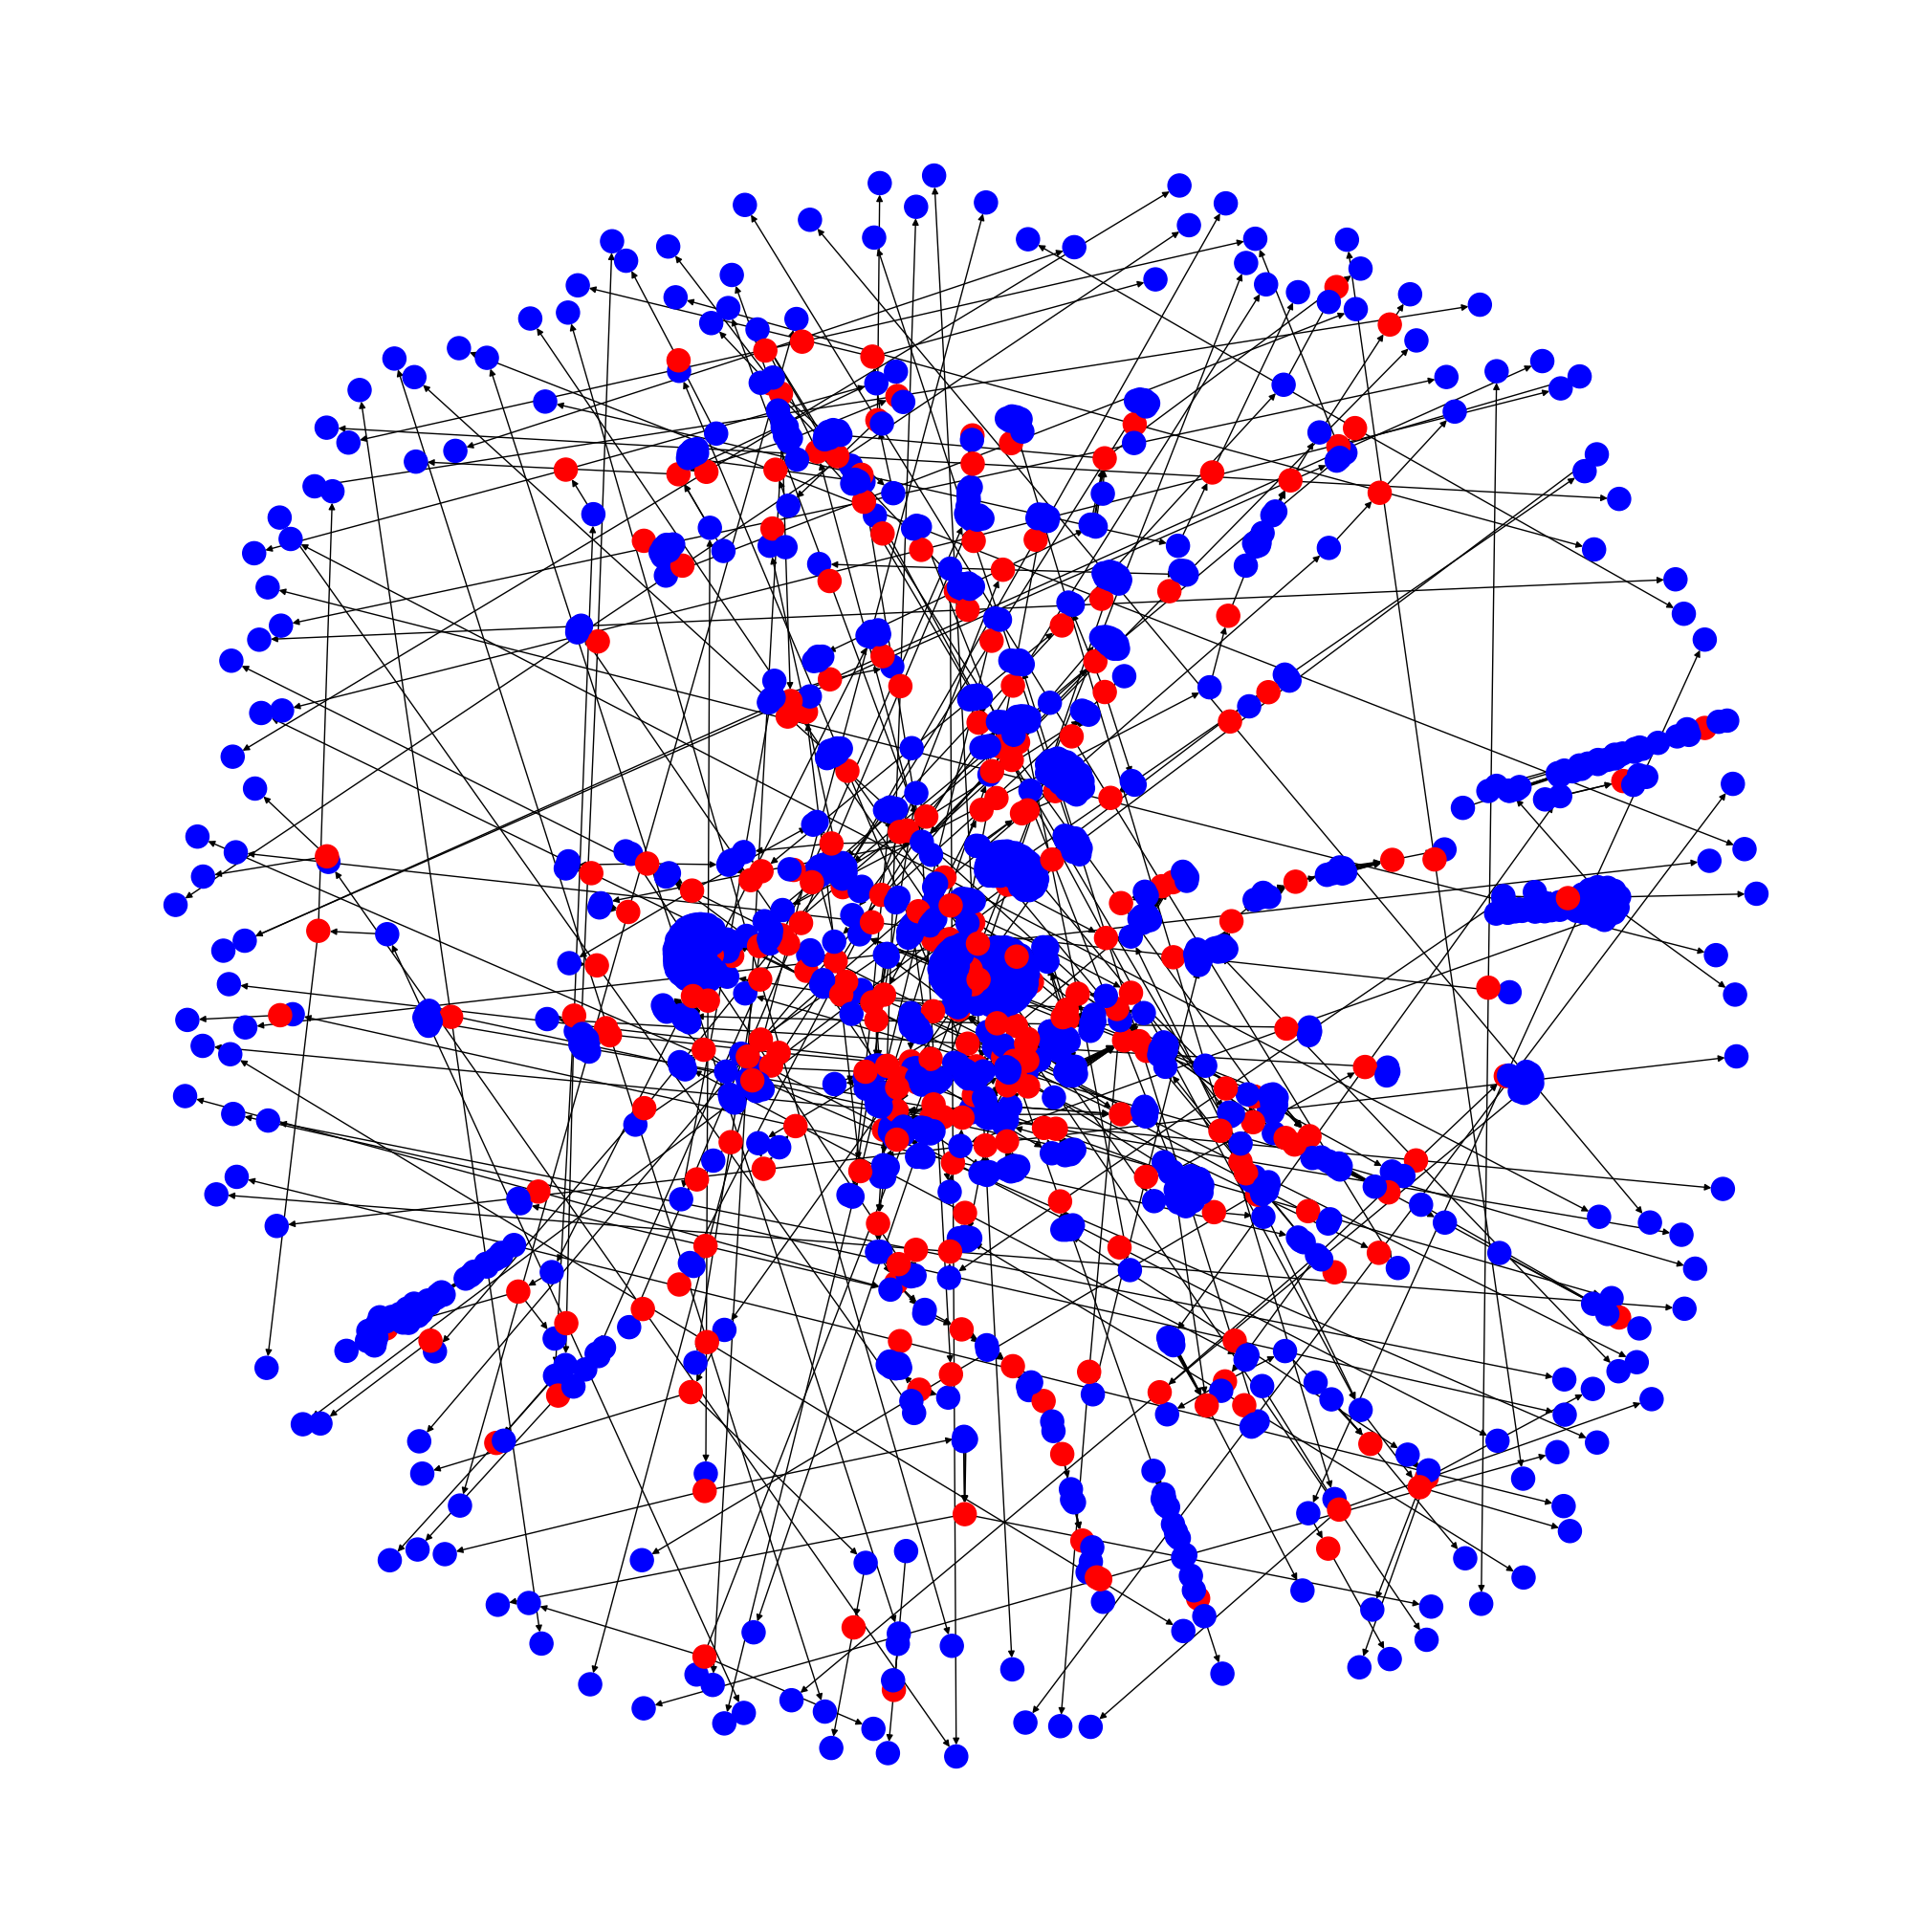

In [75]:
node_colors = []
for node in nx_g.nodes(data=True):
    if node[1]['data']['type'] == 'transaction':
        node_colors.append('red')
    else:
        node_colors.append('blue')  # or any other color for non-transaction nodes
plt.figure(figsize=(20, 20))
nx.draw(nx_g, with_labels=False, arrowsize=10, node_color=node_colors, font_size=6)
plt.show()


Un po' di analisi

In [76]:
# 2. Calcolo del numero di nodi e archi
num_nodes = nx_g.number_of_nodes()
num_edges = nx_g.number_of_edges()
print("Total number of nodes: ", num_nodes)
print("Total number of edges: ", num_edges)
# Contiamo quante transazioni abbiamo
transaction_count = sum(1 for node, data in nx_g.nodes(data=True) if data['data']['type'] == 'transaction')
print("Number of nodes of type transactions: ", transaction_count)
# Contiamo quanti wallet abbiamo ora
wallet_count = sum(1 for node, data in nx_g.nodes(data=True) if data['data']['type'] == 'address')
print("Number of nodes of type wallets: ", wallet_count)

# Determinazione dei nodi di grado massimo e minimo
in_degrees = nx_g.in_degree()
out_degrees = nx_g.out_degree()

max_in_node = max(in_degrees, key=lambda x: x[1])
max_out_node = max(out_degrees, key=lambda x: x[1])
print(f"Nodo con grado di ingresso massimo: {max_in_node}, di tipo {nx_g.nodes[max_in_node[0]]['data']['type']}")
print(f"Nodo con grado di uscita massimo: {max_out_node}, di tipo {nx_g.nodes[max_out_node[0]]['data']['type']}")

is_connected = nx.is_strongly_connected(nx_g)
print(f'Il grafo è connesso (strongly connected)? {is_connected}')

# Calcolo e riassunto delle metriche di centralità
degree_centrality = nx.degree_centrality(nx_g)
betweenness_centrality = nx.betweenness_centrality(nx_g)
closeness_centrality = nx.closeness_centrality(nx_g)

# Riassunto delle centralità di grado
# Ordina i nodi in base ai valori di centralità di grado in ordine decrescente
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampa i primi 5 nodi con la centralità di grado più alta
print("Top 5 nodi per centralità di grado:")
for i, (node, centrality) in enumerate(sorted_degree_centrality[:5], 1):
    print(f"{i}. Nodo: {node}, Centralità di grado: {centrality:.4f}")
min_degree_node = min(degree_centrality, key=degree_centrality.get)

print(f'Nodo con centralità di grado minima: {min_degree_node} ({degree_centrality[min_degree_node]:.4f})')

# Riassunto delle centralità di betweenness
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
min_betweenness_node = min(betweenness_centrality, key=betweenness_centrality.get)

print(f'Nodo con centralità di betweenness massima: {max_betweenness_node} ({betweenness_centrality[max_betweenness_node]:.4f})')
print(f'Nodo con centralità di betweenness minima: {min_betweenness_node} ({betweenness_centrality[min_betweenness_node]:.4f})')

# Riassunto delle centralità di closeness
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
min_closeness_node = min(closeness_centrality, key=closeness_centrality.get)

print(f'Nodo con centralità di closeness massima: {max_closeness_node} ({closeness_centrality[max_closeness_node]:.4f})')
print(f'Nodo con centralità di closeness minima: {min_closeness_node} ({closeness_centrality[min_closeness_node]:.4f})')



Total number of nodes:  1766
Total number of edges:  1878
Number of nodes of type transactions:  272
Number of nodes of type wallets:  1494
Nodo con grado di ingresso massimo: ('8ebe1df6ebf008f7ec42ccd022478c9afaec3ca0444322243b745aa2e317c272', 114), di tipo transaction
Nodo con grado di uscita massimo: ('19aArXjA8p6DAkBvGoheeH3GqBG4TbMBSE', 5), di tipo address
Il grafo è connesso (strongly connected)? False
Top 5 nodi per centralità di grado:
1. Nodo: 8ebe1df6ebf008f7ec42ccd022478c9afaec3ca0444322243b745aa2e317c272, Centralità di grado: 0.0657
2. Nodo: a09ac44c71a314316431f53dcf51d5c0ffdf85b738a6b07f622012ee41b38c16, Centralità di grado: 0.0646
3. Nodo: 98fd4c1596b907e05aa8b5aaaace6c46c9e3d36d7869dad3d96af3f43aa51ccc, Centralità di grado: 0.0414
4. Nodo: 9dde47a12e54a7f94cdbd75cd5bdaef8304afe7096ca4a7ea26bc3290e6b98c9, Centralità di grado: 0.0300
5. Nodo: e54e1b90060f84bf7acbfe60108dab2d734024836d4cf0636a201db2da4d0bf4, Centralità di grado: 0.0283
Nodo con centralità di grado minima: 

Dall'analisi sovrastante, effettuata con k=320, possiamo fare un bel po' di analisi.
Innanzitutto, abbiamo aggiunto un totale di 1766 nodi, di cui 1494 sono di tipo wallet e 272 (sulle sui 320 richiesti) di tipo transazione. Averne trovati 272 di tipo transazione e non 320, come richiesto, per come è scritto lo scraper, significa che abbiamo trovato probabilmente più di 50 UXTO potenzialmente.

Nel processo di discovery, abbiamo trovato ben 1494 wallets, questo ci indica che le transazioni hanno spesso molti input e molti output.
Per vedere meglio questo dettaglio, vediamo quali sono i nodi con grado max e min.
Sono entrambi transaction nodes e inserendoli su WalletExplorer possiamo vedere meglio cosa sono.

- [Il nodo di grado di entrata massimo risulta essere questo](https://www.walletexplorer.com/txid/8ebe1df6ebf008f7ec42ccd022478c9afaec3ca0444322243b745aa2e317c272), con ben 117 input ed un totale di 230 BTC in uscita.
- [Andando avanti con il nodo di grado uscita massimo](https://www.walletexplorer.com/wallet/CoinJoinMess?from_address=19aArXjA8p6DAkBvGoheeH3GqBG4TbMBSE), Questo è un address apparartenente ad un CoinJoin (WalletExplorer per natura della cosa li mette tutti in CoinJoinMess). I CoinJoin sono operazioni che si effettuano con gli UXTO, in cui si creano una serie di transazioni in cui vari UXTO vengono mischiati così da anonimizzare il più possibile la provenienza dei BTC.
Entrambe queste transazioni sono ben visibili nel grafico del grafo, poichè sono rappresentate da cluster consistenti di nodi BLU. 
In particolare quella di grado massimo si vede benissimo.
- Parlando del grado di connessione del grafo, come ci aspettiamo è molto basso e infatti le componenti connesse hanno sempre un solo elemento, i wallet man mano interagiscono poco fra di loro
- Il nodo con centralità di grado massima è in questo caso quello con grado di ingresso massimo, già studiato
- Il nodo con centralità di grado minima, invece, è proprio la coinbase che stiamo considerando e da cui siamo partiti! Questo perché ha 0 input mentre tutti gli altri non essendo coinbase hanno almeno 1 input


Fun fact, seguendo uno dei nodi con ingresso massimo trovato durante altre analisi,- [si arriva qui](https://www.walletexplorer.com/txid/3f807ab02e86aabc9ea92acf9dea585760a3aa3fc8f4501b078af8288e682c26), notiamo che effettivamente ha in input ben 218 transactions differenti, di cui i fondi provengono da 188 wallet differenti.
In totale questa transazione ha spostato ben 11000 BTC verso [questo](https://www.walletexplorer.com/address/1NZ8KAMPwhCUpFNe7yqAEWNy4X9dt1Juhs) wallet. La cosa interessantissima è che seguendo manualmente il flusso, arriviamo a [questo](https://www.walletexplorer.com/address/1F34duy2eeMz5mSrvFepVzy7Y1rBsnAyWC) wallet, che ha quella transaction da circa 11k BTC unspent e CONTINUA ad oggi ad essere ancora attivo, avendo transazioni in entrata del 2024. Su [bitinfocharts](https://bitinfocharts.com/top-100-richest-bitcoin-addresses.html) questo è il 73esimo wallet più ricco al mondo e non si sa a chi è associato. Continuando a fare ricerche su [1F34duy2eeMz5mSrvFepVzy7Y1rBsnAyWC](https://www.walletexplorer.com/address/1F34duy2eeMz5mSrvFepVzy7Y1rBsnAyWC) possiamo arrivare [qui](https://bitcointalk.org/index.php?topic=140356.0). Dove una discussione fra utenti del forum nel 2013, ipotizzava che questo wallet insieme a molti altri contenenti fondi così ingenti, sia ormai perso. Questa è una ipotesi e probabilmente non è così poiché alcuni di quei portafogli si sono scoperti essere in realtà attivi.

Altre citazioni a quel wallet [qui](https://bitcointalk.org/index.php?topic=295302.20)


Addirittura, se si espande k, si può arrivare a vedere come dalla coinbase data dalla traccia, si arrivi ad un portafoglio di SilkRoad (quel silkroad).

##### 4.4 Seguiamo solo il flusso in output adesso
Invece di considerare anche gli input e creare un nodo per ogni transazione, ora seguiamo solo gli output e vediamo in quali portafogli man mano vanno a finire i fondi.
Consideriamo che questa è una analisi riduttiva poiché man mano vengono mischiati con altri fondi in input.

In [ ]:
k = float("inf")
k = 10 # Per iniziare scendiamo in profondità 50.

# Creo il grafo vuoto 
nx_g = nx.DiGraph()  #Creiamo un grafico direzionato

start_transaction = ["c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"] #Questa è presa dalla traccia
# Scrivo una iterativa per gestirla meglio ed uso una specie di BFS
queue = set(start_transaction)
prev_outputs = []
nx_g.add_node(start_transaction[0], data={"type":"transaction", "coinbase": True})
first = True
while queue and k > 0:
    k -= 1
    current_transaction = queue.pop()
    print("Currently evaluating transaction: ", current_transaction)
    if current_transaction is None:
        continue
    # Creo un nodo per la transazione
    # Estraggo le informazioni della transazione corrente
    current_info = scrape_transaction(current_transaction)
    # Aggiungo gli output
    new_prevs = []
    for output in current_info['outputs']:
            
        nx_g.add_node(output['to_address'], data={"type":"address", "type2":"output", "coinbase": current_info['coinbase']})
        if first:
            nx_g.add_edge(current_transaction, output['to_address'], data={"amount": output['amount']})
            first = False
        #nx_g.add_edge(current_transaction, output['to_address'], data={"amount": output['amount']})
        for element in prev_outputs:
            nx_g.add_edge(element, output['to_address'], data={"amount": output['amount']})
        queue.add(output['out_transaction']) # Per fare in modo di continuare a scendere in profondità nel grafo aggiungo le prossime transazioni alla queue :)
        new_prevs.append(output['to_address'])
    prev_outputs = new_prevs
    

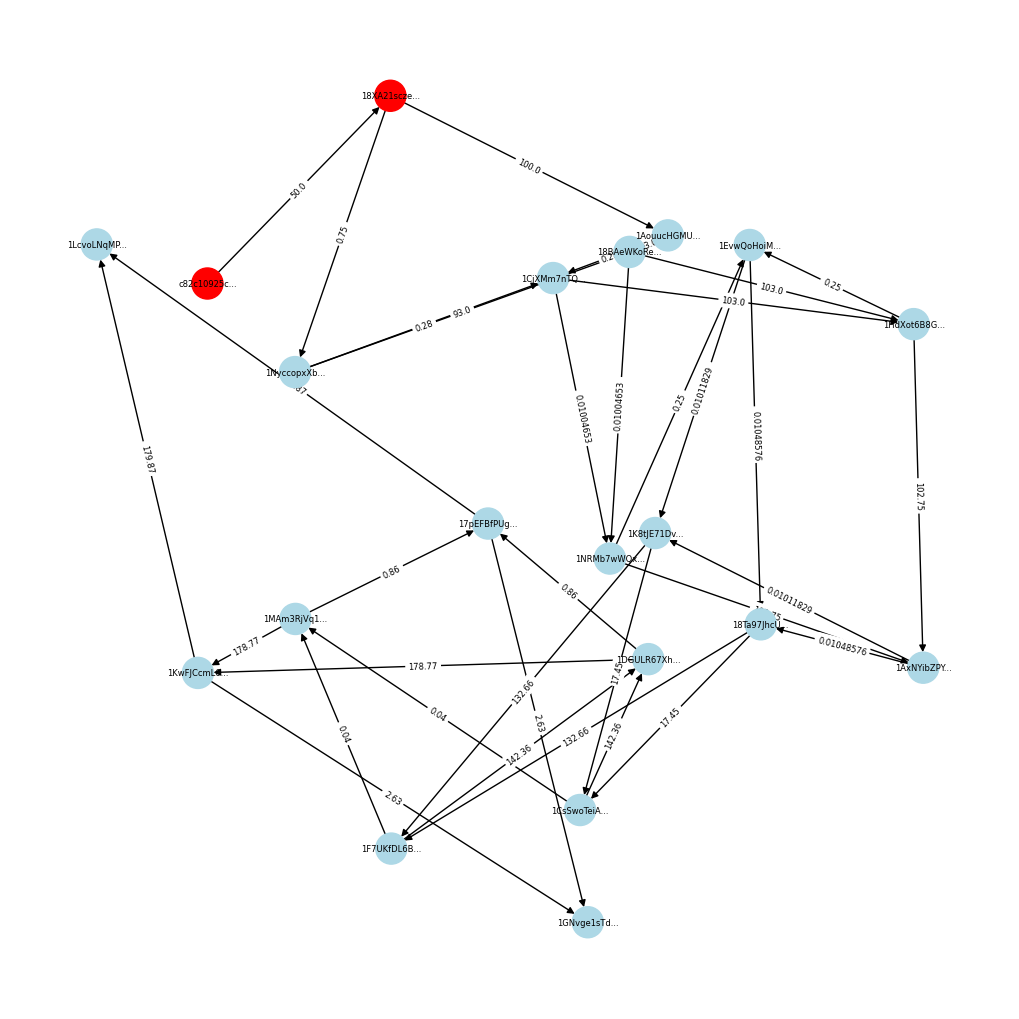

In [71]:
# Funzione per troncare i nomi dei nodi
def truncate_label(label, max_length=10):
    label_str = str(label)
    if len(label_str) > max_length:
        return label_str[:max_length] + "..."
    return label_str

# Crea un nuovo dizionario di etichette dei nodi troncate
truncated_labels = {node: truncate_label(node) for node in nx_g.nodes()}

# Colora i nodi in base al tipo (coinbase o no)
node_colors = []
for node in nx_g.nodes():
    node_data = nx_g.nodes[node].get("data", {})
    if node_data.get("coinbase", False):
        node_colors.append("red")
    else:
        node_colors.append("lightblue")

# Disegna il grafo con le etichette dei nodi troncate
plt.figure(figsize=(10, 10))
# Aumenta lo spazio tra i nodi con il parametro k
pos = nx.spring_layout(nx_g,k=1)  # Modifica il valore di k per aumentare la distanza tra i nodi
nx.draw(nx_g, pos, labels=truncated_labels, with_labels=True, font_size=6, node_size=500, node_color=node_colors, arrowsize=10)

# Etichette degli archi (amount)
edge_labels = {(u, v): f"{d['data']['amount']}" for u, v, d in nx_g.edges(data=True)}
nx.draw_networkx_edge_labels(nx_g, pos, edge_labels=edge_labels, font_size=6)

plt.show()


In [73]:
# 2. Calcolo del numero di nodi e archi
num_nodes = nx_g.number_of_nodes()
num_edges = nx_g.number_of_edges()
print("Total number of nodes: ", num_nodes)
print("Total number of edges: ", num_edges)
# Contiamo quante transazioni abbiamo
transaction_count = sum(1 for node, data in nx_g.nodes(data=True) if data['data']['type'] == 'transaction')
print("Number of nodes of type transactions: ", transaction_count)
# Contiamo quanti wallet abbiamo ora
wallet_count = sum(1 for node, data in nx_g.nodes(data=True) if data['data']['type'] == 'address')
print("Number of nodes of type wallets: ", wallet_count)

# Determinazione dei nodi di grado massimo e minimo
in_degrees = nx_g.in_degree()
out_degrees = nx_g.out_degree()

max_in_node = max(in_degrees, key=lambda x: x[1])
max_out_node = max(out_degrees, key=lambda x: x[1])
print(f"Nodo con grado di ingresso massimo: {max_in_node}, di tipo {nx_g.nodes[max_in_node[0]]['data']['type']}")
print(f"Nodo con grado di uscita massimo: {max_out_node}, di tipo {nx_g.nodes[max_out_node[0]]['data']['type']}")

is_connected = nx.is_strongly_connected(nx_g)
print(f'Il grafo è connesso (strongly connected)? {is_connected}')


# Calcolo e riassunto delle metriche di centralità
degree_centrality = nx.degree_centrality(nx_g)
betweenness_centrality = nx.betweenness_centrality(nx_g)
closeness_centrality = nx.closeness_centrality(nx_g)

# Riassunto delle centralità di grado
max_degree_node = max(degree_centrality, key=degree_centrality.get)
min_degree_node = min(degree_centrality, key=degree_centrality.get)

print(f'Nodo con centralità di grado massima: {max_degree_node} ({degree_centrality[max_degree_node]:.4f})')
print(f'Nodo con centralità di grado minima: {min_degree_node} ({degree_centrality[min_degree_node]:.4f})')

# Riassunto delle centralità di betweenness
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
min_betweenness_node = min(betweenness_centrality, key=betweenness_centrality.get)

print(f'Nodo con centralità di betweenness massima: {max_betweenness_node} ({betweenness_centrality[max_betweenness_node]:.4f})')
print(f'Nodo con centralità di betweenness minima: {min_betweenness_node} ({betweenness_centrality[min_betweenness_node]:.4f})')

# Riassunto delle centralità di closeness
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
min_closeness_node = min(closeness_centrality, key=closeness_centrality.get)

print(f'Nodo con centralità di closeness massima: {max_closeness_node} ({closeness_centrality[max_closeness_node]:.4f})')
print(f'Nodo con centralità di closeness minima: {min_closeness_node} ({closeness_centrality[min_closeness_node]:.4f})')



Total number of nodes:  20
Total number of edges:  35
Number of nodes of type transactions:  1
Number of nodes of type wallets:  19
Nodo con grado di ingresso massimo: ('1CjXMm7nTQevWeVHVXvFMHA8FHTmscbDfc', 2), di tipo address
Nodo con grado di uscita massimo: ('18XA21sczeZkqrYYuQoN9KHQEQe2G2haJg', 2), di tipo address
Il grafo è connesso (strongly connected)? False
Nodo con centralità di grado massima: 1CjXMm7nTQevWeVHVXvFMHA8FHTmscbDfc (0.2105)
Nodo con centralità di grado minima: c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6 (0.0526)
Nodo con centralità di betweenness massima: 1AxNYibZPYXPDpvAiAQruXZ4NMno2PaG3c (0.1170)
Nodo con centralità di betweenness minima: c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6 (0.0000)
Nodo con centralità di closeness massima: 1LcvoLNqMPLWYZ2EtxcQATPYqfXHZVPxji (0.1874)
Nodo con centralità di closeness minima: c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6 (0.0000)
